---
# Libraries
---

In [1]:
import pandas as pd
import numpy as np
import random
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima.arima import auto_arima
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
import itertools
import warnings
from statsmodels.tsa.statespace.varmax import VARMAX
warnings.filterwarnings("ignore")

---
# Read Pasifik Raw Data
---

In [2]:
raw = pd.read_excel("../data/_pasifik_sales_portfoy.xlsx")

In [3]:
df = raw.copy()

In [4]:
df = df[(df["scope"] == 1) & (df["portfoy"] == 1)]

In [5]:
cols_keep = ['grup_adi', 'ana_kategori_adi', 'kategori_adi', 'marka_adi', 'urun_adi', 
             'adet', 'enflasyon_etkisi', 'date', 'peak', 'fiyat', 'fiyat_gecisi', 
             'aktivite_tipi', 'indirim__', 'weekdays_n', 'weekend_n', 'actual_holiday_n', 
             'school_day_n', 'ramadan_n', 'pandemic', 'lockdown']

In [6]:
df = df[cols_keep]

In [7]:
df_all = []
for sku in df["urun_adi"].unique():
    temp_df = df[df["urun_adi"] == sku].reset_index(drop=True)
    df_all.append(temp_df)

In [8]:
sku1, sku2, sku3, sku4, sku5 = df_all[0], df_all[1], df_all[2], df_all[3], df_all[4]

In [9]:
print("sku1:", sku1.urun_adi.unique()[0])
print("sku2:", sku2.urun_adi.unique()[0])
print("sku3:", sku3.urun_adi.unique()[0])
print("sku4:", sku4.urun_adi.unique()[0])
print("sku5:", sku5.urun_adi.unique()[0])

sku1: ONEO SLIMS Y.NANE ARO.TAT.SAK.14Gx27x6
sku2: CARAMIO KARE ÇİK.K.MELLİ 60Gx12x6
sku3: ONEO DRAJE ŞİŞE NANE AR.DOL.SAK.76Gx12
sku4: HALLEY KARADUT DOL.7x33,7Gx12
sku5: ULK PÖTİBÖR BİSK.1000Gx5


In [10]:
# sku1 = ONEO SLIMS Y.NANE ARO.TAT.SAK.14Gx27x6
# sku2 = CARAMIO KARE ÇİK.K.MELLİ 60Gx12x6
# sku3 = ONEO DRAJE ŞİŞE NANE AR.DOL.SAK.76Gx12
# sku4 = HALLEY KARADUT DOL.7x33,7Gx12
# sku5 = ULK PÖTİBÖR BİSK.1000Gx5

In [11]:
sku1.set_index("date", inplace=True)
sku2.set_index("date", inplace=True)
sku3.set_index("date", inplace=True)
sku4.set_index("date", inplace=True)
sku5.set_index("date", inplace=True)

In [12]:
sku1__backup = sku1.copy()
sku2__backup = sku2.copy()
sku3__backup = sku3.copy()
sku4__backup = sku4.copy()
sku5__backup = sku5.copy()

---
# ALL ANALYSIS FOR SKU1
---

## EDA (SKU1)
---

In [13]:
sku1.columns

Index(['grup_adi', 'ana_kategori_adi', 'kategori_adi', 'marka_adi', 'urun_adi',
       'adet', 'enflasyon_etkisi', 'peak', 'fiyat', 'fiyat_gecisi',
       'aktivite_tipi', 'indirim__', 'weekdays_n', 'weekend_n',
       'actual_holiday_n', 'school_day_n', 'ramadan_n', 'pandemic',
       'lockdown'],
      dtype='object')

In [14]:
sku1.describe().T

,count,mean,std,min,25%,50%,75%,max
adet,51.0,163399.235453,142320.879841,58158.00,101898.00,136593.00054,174069.000,841266.00
enflasyon_etkisi,51.0,13.876275,4.035855,8.55,11.07,11.92000,15.785,25.24
peak,51.0,0.039216,0.196039,0.00,0.00,0.00000,0.000,1.00
fiyat,51.0,138.097059,14.777892,119.88,119.88,149.85000,149.850,149.85
fiyat_gecisi,51.0,0.000000,0.000000,0.00,0.00,0.00000,0.000,0.00
indirim__,51.0,0.000000,0.000000,0.00,0.00,0.00000,0.000,0.00
weekdays_n,51.0,21.725490,1.059782,20.00,21.00,22.00000,23.000,23.00
weekend_n,51.0,8.686275,0.787152,8.00,8.00,8.00000,9.000,10.00
actual_holiday_n,51.0,9.558824,1.518707,8.00,9.00,9.00000,10.000,14.00
school_day_n,51.0,11.656863,9.394940,0.00,0.00,14.00000,21.000,23.00


### İndirim ve Fiyat atıldı çünkü std mean median q1, q3'ler hep aynı

In [15]:
sku1_backup = sku1.copy()

### Tekrarlamayan peak noktalarına ortalama atandı

In [16]:
idx = list(sku1[sku1["peak"] == 1].index)

In [17]:
mean1 = sku1.adet.mean()
sku1.loc[idx[0], "adet"] = mean1
sku1.loc[idx[1], "adet"] = mean1

In [17]:
sku1.drop(columns=["fiyat_gecisi", "indirim__"], axis=1, inplace=True)

In [18]:
sku1.corr()

,adet,enflasyon_etkisi,peak,fiyat,weekdays_n,weekend_n,actual_holiday_n,school_day_n,ramadan_n,pandemic,lockdown
adet,1.000000,-0.111908,0.950700,0.038055,0.050386,-0.065125,-0.138290,0.006622,-0.188460,0.019278,-0.115578
enflasyon_etkisi,-0.111908,1.000000,-0.172969,0.411505,0.005227,-0.001823,-0.014549,0.059380,-0.025822,-0.123980,-0.137074
peak,0.950700,-0.172969,1.000000,-0.044626,0.052852,-0.048285,-0.075079,0.072607,-0.074438,-0.118167,-0.040816
fiyat,0.038055,0.411505,-0.044626,1.000000,-0.018761,0.037383,-0.021994,-0.195844,-0.078215,0.469801,0.162275
weekdays_n,0.050386,0.005227,0.052852,-0.018761,1.000000,-0.584797,-0.163734,-0.029737,0.102289,0.024381,-0.043414
weekend_n,-0.065125,-0.001823,-0.048285,0.037383,-0.584797,1.000000,0.534378,-0.032427,-0.054292,0.004528,0.081322
actual_holiday_n,-0.138290,-0.014549,-0.075079,-0.021994,-0.163734,0.534378,1.000000,-0.310440,0.239875,-0.007920,0.260800
school_day_n,0.006622,0.059380,0.072607,-0.195844,-0.029737,-0.032427,-0.310440,1.000000,-0.026683,-0.585422,-0.253166
ramadan_n,-0.188460,-0.025822,-0.074438,-0.078215,0.102289,-0.054292,0.239875,-0.026683,1.000000,-0.002368,0.404094
pandemic,0.019278,-0.123980,-0.118167,0.469801,0.024381,0.004528,-0.007920,-0.585422,-0.002368,1.000000,0.345412


In [19]:
#sku1 = sku1[["adet", "ramadan_n", "pandemic", "lockdown"]]
sku1 = sku1[["adet", "peak"]]

### Histogram grafiği

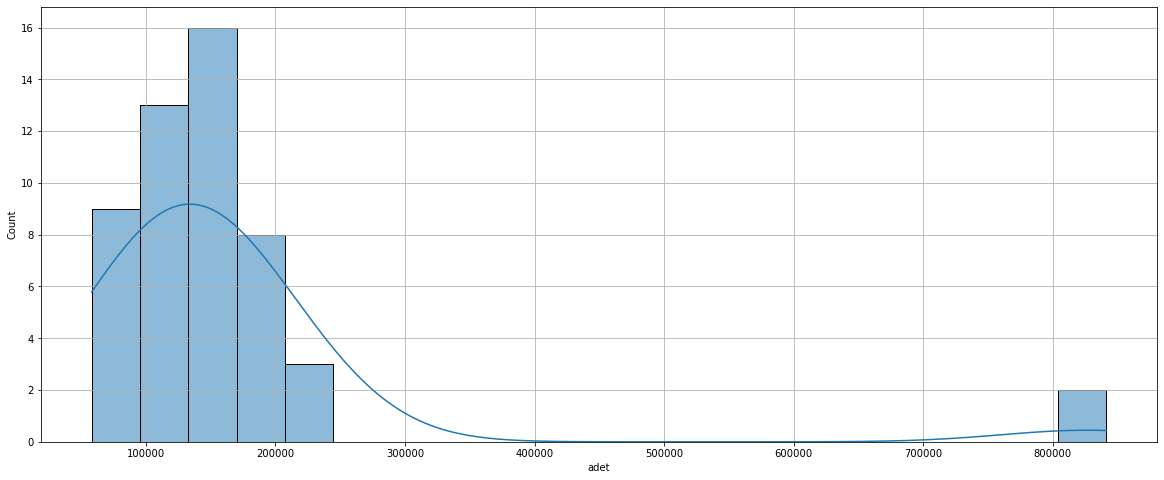

In [20]:
plt.figure(figsize=(20, 8))
sns.histplot(x="adet", data=sku1, kde=True)
plt.grid()
plt.show()

In [21]:
X1 = sku1.drop("adet", axis=1)
y1 = sku1.adet

In [22]:
train_size = -6
X1_train, X1_test, y1_train, y1_test = X1[:train_size], X1[train_size:], y1[:train_size], y1[train_size:]

In [23]:
X1_train.shape, X1_test.shape, y1_train.shape, y1_test.shape

((45, 1), (6, 1), (45,), (6,))

In [24]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 8

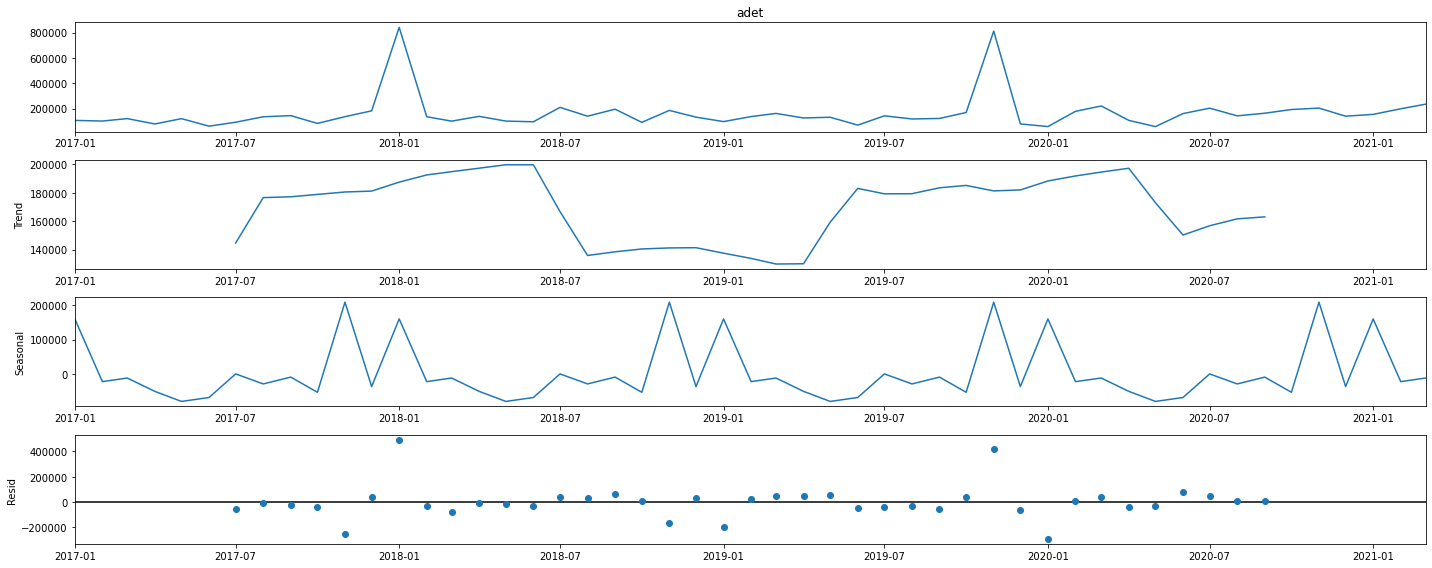

In [25]:
seas_d = sm.tsa.seasonal_decompose(y1, model="add")
seas_d.plot()
plt.show()

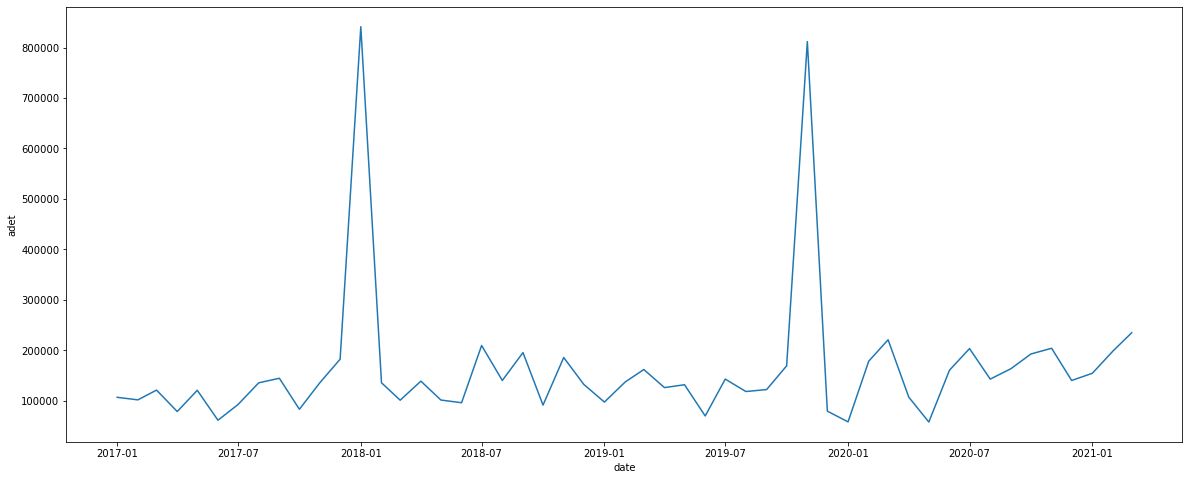

In [26]:
sns.lineplot(x=X1.index, y=y1, data=X1);

In [27]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / y_true)) * 100

def wmape(y_true, y_pred): 
    return np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.abs(y_true))) * 100

In [28]:
y_stationarity = y1[:train_size]
def adfuller_test_results(data):
    results = adfuller(data)
    print("ADF Statistics: %f" % results[0])
    print("p-value: %f" % results[1])
    print("Critical Values:")
    for key, value in results[4].items():
        print("\t%s: %.3f" % (key, value))
    if results[1] < 0.05:
        print("There is stationary. The data might be OK. You should also check the variance.")
    else:
        print("There is no stationary. You have to transform your data.")
adfuller_test_results(y_stationarity)

ADF Statistics: -6.518682
p-value: 0.000000
Critical Values:
	1%: -3.589
	5%: -2.930
	10%: -2.603
There is stationary. The data might be OK. You should also check the variance.


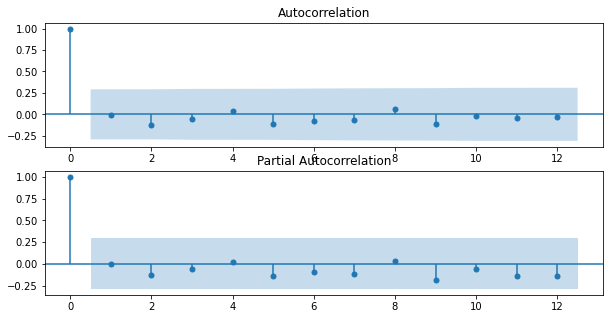

In [29]:
fig,ax= plt.subplots(2,1, figsize=(10,5))
fig=sm.tsa.graphics.plot_acf(y_stationarity, lags=12, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(y_stationarity, lags=12, ax=ax[1])
plt.show()

In [30]:
X1_train = sm.add_constant(X1_train)
X1_test = sm.add_constant(X1_test)

In [31]:
arima_model = auto_arima(y=y1_train, X=X1_train,
                        start_p=0, start_q=0,
                        max_p=13, max_q=13,m=12,
                        start_P=0, seasonal=True,
                        d=1, D=1, trace=True,
                        error_action="ignore",
                        suppress_warnings=True,
                        stepwise=True,
                        njobs=-1)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=808.037, Time=0.06 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=892.176, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=808.104, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=799.570, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=802.427, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=801.539, Time=0.12 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=801.524, Time=0.17 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=801.122, Time=0.14 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=803.342, Time=0.53 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=801.027, Time=0.23 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=800.765, Time=0.24 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=806.689, Time=0.09 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=802.144, Time=0.32 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=inf, Time=nan sec

Best model:  ARIMA(0,1,1)(0,1,1)[12] 

In [32]:
tuned_sarimax_model = sm.tsa.statespace.SARIMAX(y1_train,
                                         order=arima_model.order,
                                         seasonal_order=arima_model.seasonal_order,
                                         exog=X1_train,
                                         enforce_invertibility=False,
                                         enforce_stationarity=False)
decomposition = tuned_sarimax_model.fit()
print(decomposition.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               adet   No. Observations:                   45
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -221.166
Date:                            Tue, 22 Jun 2021   AIC                            452.331
Time:                                    20:44:24   BIC                            456.783
Sample:                                01-01-2017   HQIC                           452.945
                                     - 09-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.259e-06   2.27e+05   9.95e-12      1.000   -4.45e+05    4.45e+05
peak        6.732e+05   1.01e+05   

In [33]:
X1_test = sm.add_constant(X1_test)

In [34]:
try:
    X1_test.insert(loc=0, column="const", value=1.0)
except:
    pass

In [35]:
pred_uc = decomposition.get_forecast(steps=6, exog=X1_test)
pred_ci = pred_uc.conf_int()

In [42]:
predicted = decomposition.forecast(6, exog=X1_test)
y_pred = pd.DataFrame(predicted)
y_pred

,predicted_mean
2020-10-01,165679.013709
2020-11-01,192122.580117
2020-12-01,160519.267501
2021-01-01,165619.832998
2021-02-01,208162.479288
2021-03-01,218321.858621


In [37]:
lower_bound = pd.DataFrame(pred_ci.iloc[:,0])
lower_bound = pd.DataFrame(lower_bound, index=pred_ci.index, columns=["lower_bound"])
lower_bound

upper_bound = pd.DataFrame(pred_ci.iloc[:,1])
upper_bound = pd.DataFrame(upper_bound, index=pred_ci.index, columns=["upper_bound"])
upper_bound

pred_ci_unscaled = pd.concat([lower_bound, upper_bound], axis=1)

In [38]:
mape1 = mean_absolute_percentage_error(sku1["adet"][y_pred.index[0]:].values, y_pred.values)

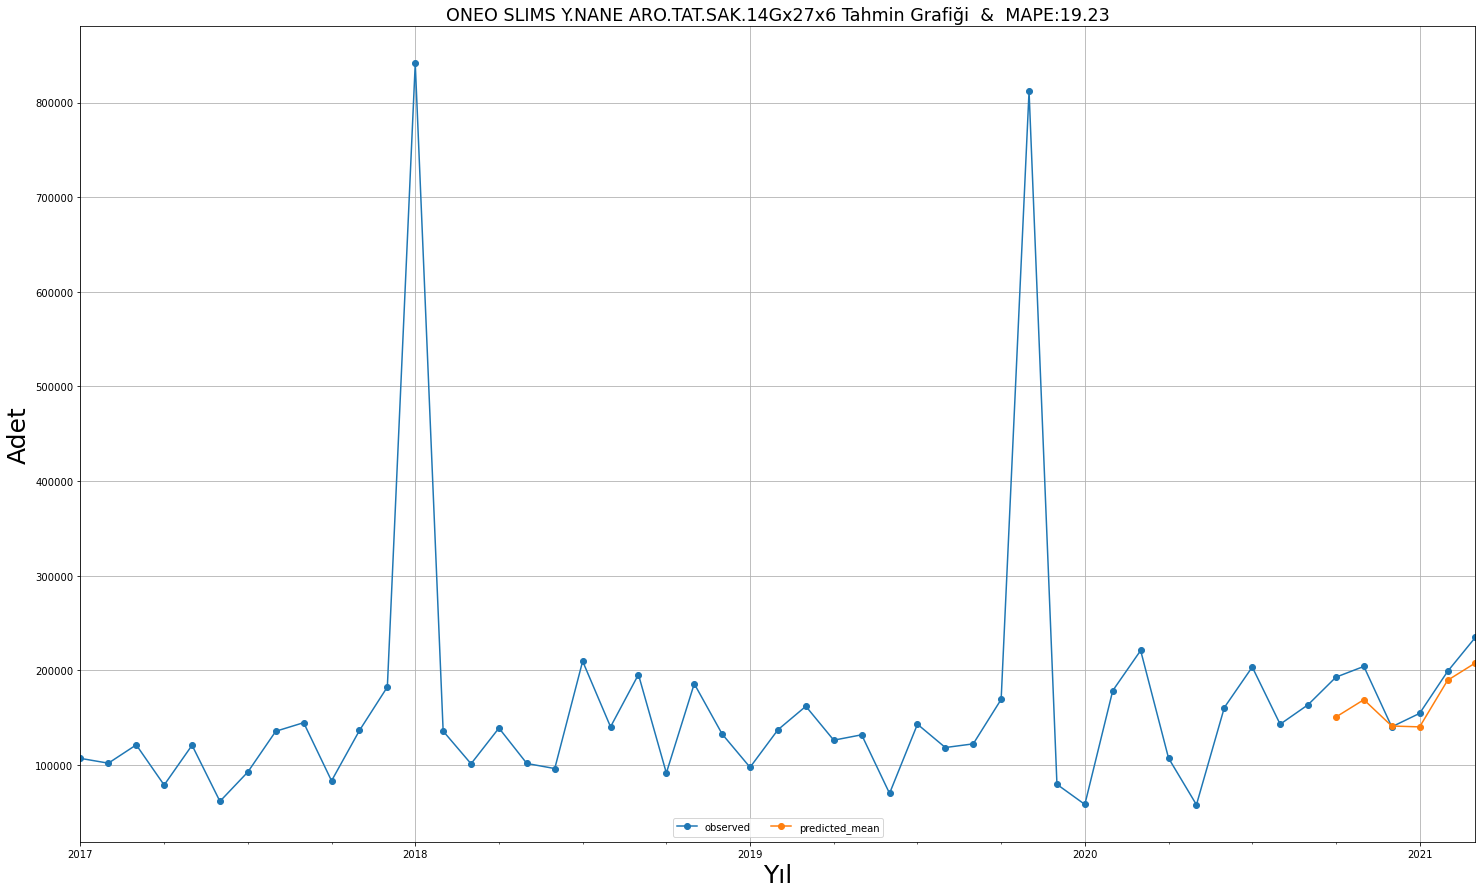

In [39]:
ax = sku1["adet"].plot(figsize=(25,15), label="observed", marker="o", y=sku1.index)
y_pred.plot(ax=ax, label="forecast", marker="o")
ax.fill_between(pred_ci_unscaled.index,
               pred_ci_unscaled.iloc[:,0],
               pred_ci_unscaled.iloc[:,1], color="k", alpha=0.25)
ax.set_xlabel("Yıl", size=25)
ax.set_ylabel("Adet", size=25)
plt.legend(loc="lower center", ncol=2)
plt.title(f"ONEO SLIMS Y.NANE ARO.TAT.SAK.14Gx27x6 Tahmin Grafiği  &  MAPE:{mape1:.2f}", 
          size=17.5)
plt.grid()
plt.show()

In [40]:
print("MAPE:",mean_absolute_percentage_error(sku1["adet"][y_pred.index[0]:].values, y_pred.values))

MAPE: 19.225145587025782


In [41]:
y_pred

,predicted_mean
2020-10-01,150831.314379
2020-11-01,169121.213999
2020-12-01,141315.453737
2021-01-01,140413.352061
2021-02-01,189581.354169
2021-03-01,208001.929643


---
# ALL ANALYSIS FOR SKU2
---

## EDA (SKU2)
---

In [42]:
sku2 = sku2__backup.copy()

In [43]:
backup_sku2 = sku2.copy()

In [44]:
sku2.columns

Index(['grup_adi', 'ana_kategori_adi', 'kategori_adi', 'marka_adi', 'urun_adi',
       'adet', 'enflasyon_etkisi', 'peak', 'fiyat', 'fiyat_gecisi',
       'aktivite_tipi', 'indirim__', 'weekdays_n', 'weekend_n',
       'actual_holiday_n', 'school_day_n', 'ramadan_n', 'pandemic',
       'lockdown'],
      dtype='object')

In [45]:
sku2.describe().T

,count,mean,std,min,25%,50%,75%,max
adet,51.0,66926.324894,52144.434985,24012.0108,38694.123,55656.00,77978.05344,382610.1564
enflasyon_etkisi,51.0,13.876275,4.035855,8.5500,11.070,11.92,15.78500,25.2400
peak,51.0,0.058824,0.237635,0.0000,0.000,0.00,0.00000,1.0000
fiyat,51.0,107.014376,23.687047,79.9200,79.920,103.68,133.20000,146.8800
fiyat_gecisi,51.0,0.078431,0.271524,0.0000,0.000,0.00,0.00000,1.0000
indirim__,51.0,0.000000,0.000000,0.0000,0.000,0.00,0.00000,0.0000
weekdays_n,51.0,21.725490,1.059782,20.0000,21.000,22.00,23.00000,23.0000
weekend_n,51.0,8.686275,0.787152,8.0000,8.000,8.00,9.00000,10.0000
actual_holiday_n,51.0,9.558824,1.518707,8.0000,9.000,9.00,10.00000,14.0000
school_day_n,51.0,11.656863,9.394940,0.0000,0.000,14.00,21.00000,23.0000


### İndirim atıldı çünkü std mean median q1, q3'ler hep aynı

### Tekrarlamayan peak noktalarına ortalama atandı

In [46]:
idx = list(sku2[sku2["peak"] == 1].index)

In [47]:
idx

[Timestamp('2017-02-01 00:00:00'),
 Timestamp('2018-01-01 00:00:00'),
 Timestamp('2021-03-01 00:00:00')]

In [48]:
mean2 = sku2.adet.mean()

In [49]:
mean2

66926.32489411764

In [50]:
print(idx[0], sku2.loc[idx[0], "adet"])
print(idx[1], sku2.loc[idx[1], "adet"])
print(idx[2], sku2.loc[idx[2], "adet"])

2017-02-01 00:00:00 132120.0
2018-01-01 00:00:00 134856.0
2021-03-01 00:00:00 382610.1564


In [132]:
sku2.loc[idx[0], "adet"] = mean2
sku2.loc[idx[1], "adet"] = mean2
sku2.loc[idx[2], "adet"] = mean2

In [51]:
#sku2.drop(["peak", "indirim__"], axis=1, inplace=True)
sku2.drop(["indirim__"], axis=1, inplace=True)

In [52]:
sku2.corr()

,adet,enflasyon_etkisi,peak,fiyat,fiyat_gecisi,weekdays_n,weekend_n,actual_holiday_n,school_day_n,ramadan_n,pandemic,lockdown
adet,1.000000,0.099036,0.724387,-0.023210,-0.015788,0.095793,-0.184710,-0.264333,0.068018,-0.090705,0.037837,-0.091113
enflasyon_etkisi,0.099036,1.000000,-0.103410,0.100617,0.066523,0.005227,-0.001823,-0.014549,0.059380,-0.025822,-0.123980,-0.137074
peak,0.724387,-0.103410,1.000000,-0.050892,-0.072932,0.065401,-0.220130,-0.203740,-0.035570,-0.092113,0.044992,-0.050508
fiyat,-0.023210,0.100617,-0.050892,1.000000,0.155966,-0.000159,0.019675,0.003593,-0.446285,-0.096492,0.728371,0.225564
fiyat_gecisi,-0.015788,0.066523,-0.072932,0.155966,1.000000,-0.132192,0.211004,0.425094,-0.189164,-0.061422,-0.003281,-0.058938
weekdays_n,0.095793,0.005227,0.065401,-0.000159,-0.132192,1.000000,-0.584797,-0.163734,-0.029737,0.102289,0.024381,-0.043414
weekend_n,-0.184710,-0.001823,-0.220130,0.019675,0.211004,-0.584797,1.000000,0.534378,-0.032427,-0.054292,0.004528,0.081322
actual_holiday_n,-0.264333,-0.014549,-0.203740,0.003593,0.425094,-0.163734,0.534378,1.000000,-0.310440,0.239875,-0.007920,0.260800
school_day_n,0.068018,0.059380,-0.035570,-0.446285,-0.189164,-0.029737,-0.032427,-0.310440,1.000000,-0.026683,-0.585422,-0.253166
ramadan_n,-0.090705,-0.025822,-0.092113,-0.096492,-0.061422,0.102289,-0.054292,0.239875,-0.026683,1.000000,-0.002368,0.404094


In [53]:
#sku2 = sku2[["adet", "school_day_n"]]
sku2 = sku2[["adet", "peak"]]

### Histogram grafiği

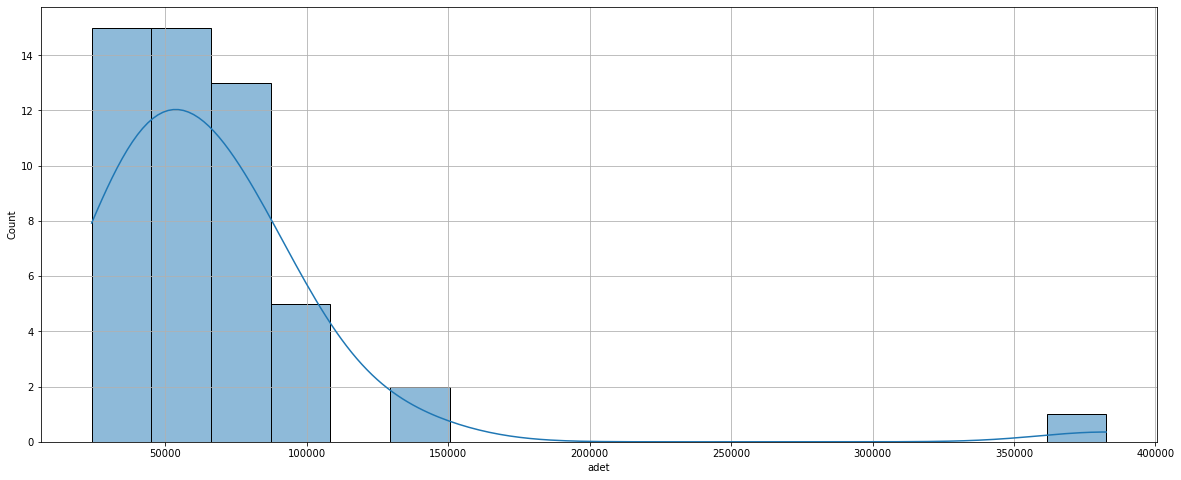

In [54]:
plt.figure(figsize=(20, 8))
sns.histplot(x="adet", data=sku2, kde=True)
plt.grid()
plt.show()

In [55]:
X2 = sku2.drop("adet", axis=1)
y2 = sku2.adet

In [56]:
idx

[Timestamp('2017-02-01 00:00:00'),
 Timestamp('2018-01-01 00:00:00'),
 Timestamp('2021-03-01 00:00:00')]

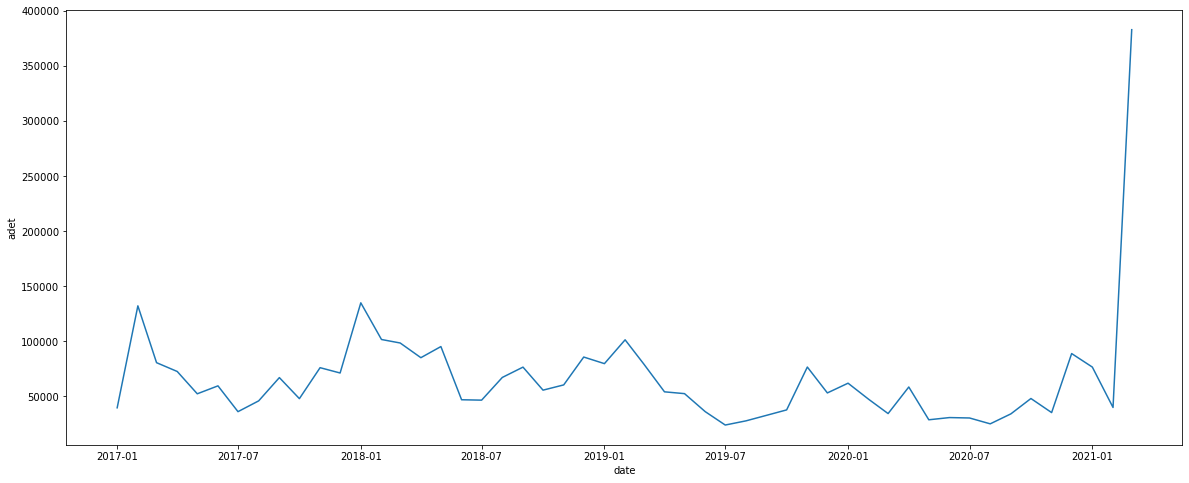

In [57]:
plt.figure(figsize=(20, 8))
sns.lineplot(x=X2.index, y=y2, data=X2);

In [58]:
train_size = -6
X2_train, X2_test, y2_train, y2_test = X2[:train_size], X2[train_size:], y2[:train_size], y2[train_size:]

In [59]:
X2_train.shape, X2_test.shape, y2_train.shape, y2_test.shape

((45, 1), (6, 1), (45,), (6,))

In [60]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 8

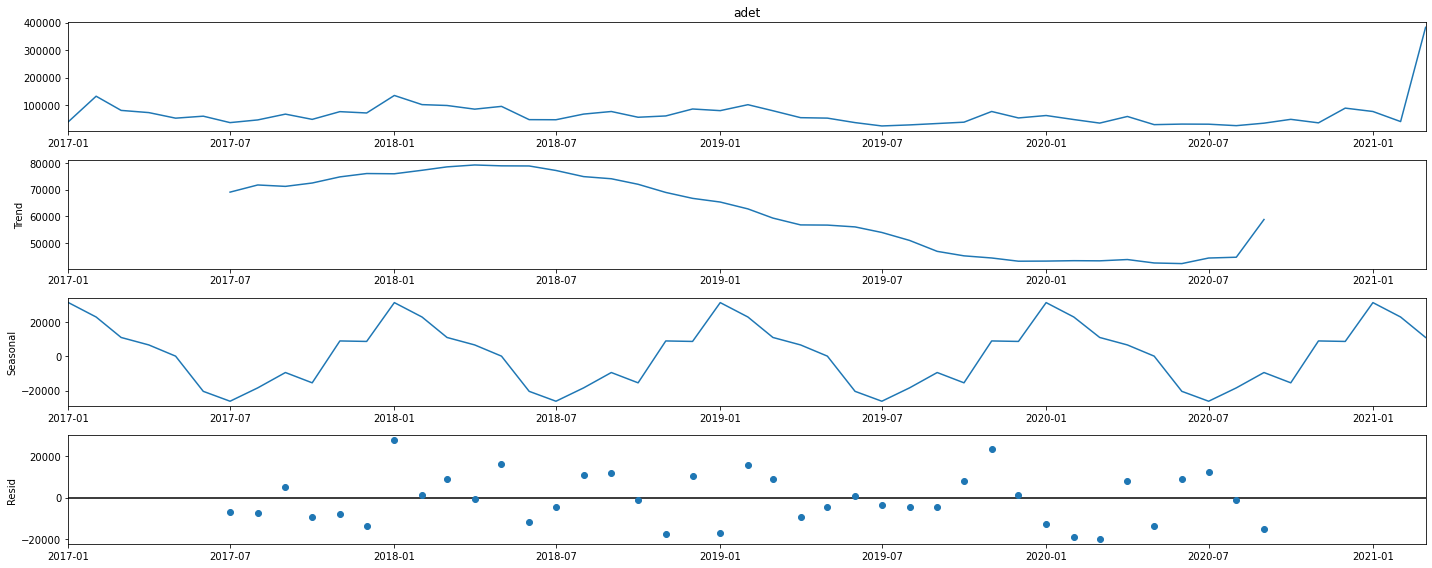

In [61]:
seas_d = sm.tsa.seasonal_decompose(y2, model="add")
seas_d.plot()
plt.show()

In [62]:
y_stationarity = y2[:train_size]
def adfuller_test_results(data):
    results = adfuller(data)
    print("ADF Statistics: %f" % results[0])
    print("p-value: %f" % results[1])
    print("Critical Values:")
    for key, value in results[4].items():
        print("\t%s: %.3f" % (key, value))
    if results[1] < 0.05:
        print("There is stationary. The data might be OK. You should also check the variance.")
    else:
        print("There is no stationary. You have to transform your data.")
adfuller_test_results(y_stationarity)

ADF Statistics: -3.562546
p-value: 0.006519
Critical Values:
	1%: -3.589
	5%: -2.930
	10%: -2.603
There is stationary. The data might be OK. You should also check the variance.


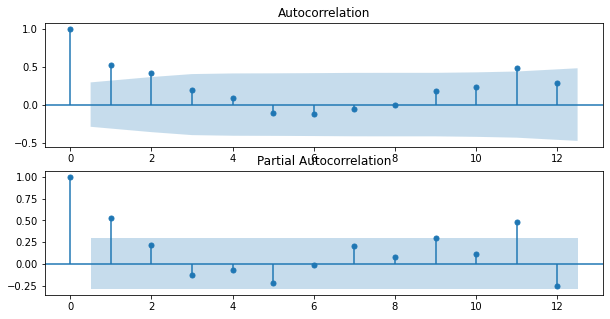

In [63]:
fig,ax= plt.subplots(2,1, figsize=(10,5))
fig=sm.tsa.graphics.plot_acf(y_stationarity, lags=12, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(y_stationarity, lags=12, ax=ax[1])
plt.show()

In [64]:
X2_train = sm.add_constant(X2_train)
X2_test = sm.add_constant(X2_test)

In [65]:
arima_model = auto_arima(y=y2_train, X=X2_train,
                        start_p=0, start_q=0,
                        max_p=13, max_q=13,m=12,
                        start_P=0, seasonal=True,
                        d=1, D=1, trace=True,
                        error_action="ignore",
                        suppress_warnings=True,
                        stepwise=True,
                        njobs=-1)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=734.406, Time=0.04 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=821.888, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=735.442, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=730.946, Time=0.06 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=736.258, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=732.929, Time=0.13 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=732.926, Time=0.19 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=733.782, Time=0.07 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=734.922, Time=0.42 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=732.928, Time=0.17 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=733.152, Time=0.14 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=732.424, Time=0.09 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=732.362, Time=0.24 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=inf, Time=nan sec

Best model:  ARIMA(0,1,1)(0,1,1)[12] 

In [66]:
tuned_sarimax_model = sm.tsa.statespace.SARIMAX(y2_train,
                                         order=arima_model.order,
                                         seasonal_order=arima_model.seasonal_order,
                                         exog=X2_train,
                                         enforce_invertibility=False,
                                         enforce_stationarity=False)
decomposition = tuned_sarimax_model.fit()
print(decomposition.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               adet   No. Observations:                   45
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -201.791
Date:                            Tue, 22 Jun 2021   AIC                            413.582
Time:                                    20:46:21   BIC                            418.034
Sample:                                01-01-2017   HQIC                           414.196
                                     - 09-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.343e-05   8.89e+04   1.51e-10      1.000   -1.74e+05    1.74e+05
peak        6.062e+04   5.03e+05   

In [67]:
pred_uc = decomposition.get_forecast(steps=6, exog=X2_test)
pred_ci = pred_uc.conf_int()

In [68]:
predicted = decomposition.forecast(6, exog=X2_test)
y_pred2 = pd.DataFrame(predicted)
y_pred2

,predicted_mean
2020-10-01,31230.141019
2020-11-01,36633.083870
2020-12-01,36293.388718
2021-01-01,57327.378425
2021-02-01,61651.117320
2021-03-01,119981.079330


In [69]:
lower_bound = pd.DataFrame(pred_ci.iloc[:,0])
lower_bound = pd.DataFrame(lower_bound, index=pred_ci.index, columns=["lower_bound"])
lower_bound

upper_bound = pd.DataFrame(pred_ci.iloc[:,1])
upper_bound = pd.DataFrame(upper_bound, index=pred_ci.index, columns=["upper_bound"])
upper_bound

pred_ci_unscaled = pd.concat([lower_bound, upper_bound], axis=1)

In [70]:
mape2 = mean_absolute_percentage_error(sku2["adet"][y_pred2.index[0]:].values, y_pred2.values)

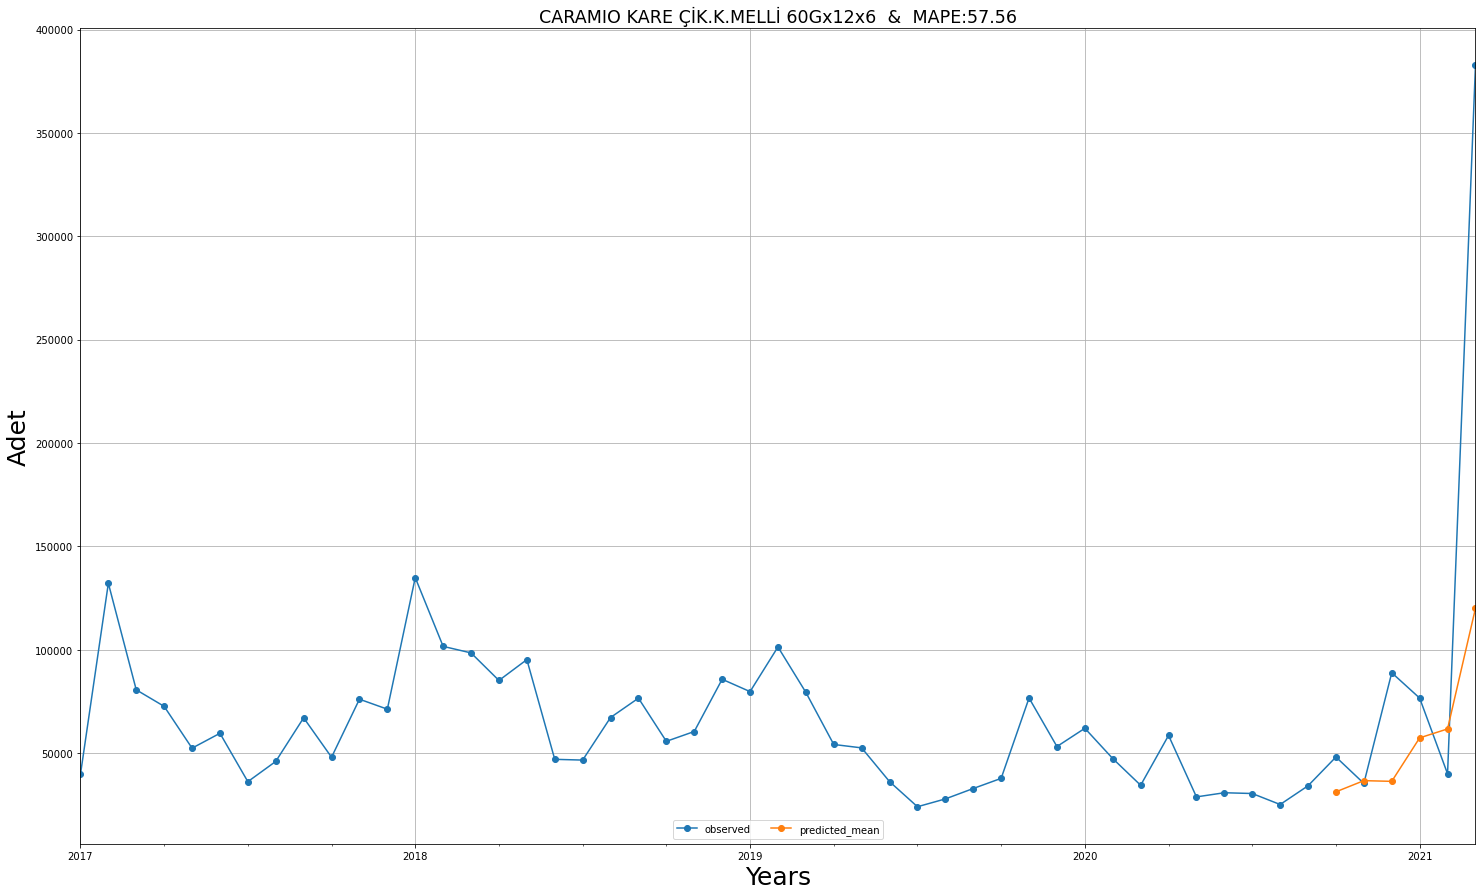

In [71]:
ax = sku2["adet"].plot(figsize=(25,15), label="observed", marker="o", y=sku2.index)
y_pred2.plot(ax=ax, label="forecast", marker="o")
ax.fill_between(pred_ci_unscaled.index,
               pred_ci_unscaled.iloc[:,0],
               pred_ci_unscaled.iloc[:,1], color="k", alpha=0.25)
ax.set_xlabel("Years", size=25)
ax.set_ylabel("Adet", size=25)
plt.legend(loc="lower center", ncol=2)
plt.title(f"CARAMIO KARE ÇİK.K.MELLİ 60Gx12x6  &  MAPE:{mape2:.2f}", 
          size=17.5)
plt.grid()
plt.show()

In [72]:
print("MAPE:",mean_absolute_percentage_error(sku2["adet"][y_pred2.index[0]:].values, y_pred2.values))

MAPE: 57.56318519721737


In [73]:
y_pred2

,predicted_mean
2020-10-01,31230.141019
2020-11-01,36633.083870
2020-12-01,36293.388718
2021-01-01,57327.378425
2021-02-01,61651.117320
2021-03-01,119981.079330


---
# ALL ANALYSIS FOR SKU3
---

## EDA (SKU3)
---

In [74]:
sku3 = sku3__backup.copy()

In [75]:
sku3.describe().T

,count,mean,std,min,25%,50%,75%,max
adet,37.0,3790.648625,6161.803954,12.00,1380.00,2424.00,3960.00,37608.00
enflasyon_etkisi,37.0,14.958919,4.226164,8.55,11.77,14.60,17.90,25.24
peak,37.0,0.054054,0.229243,0.00,0.00,0.00,0.00,1.00
fiyat,37.0,69.417437,12.649446,44.40,62.22,71.16,80.04,88.80
fiyat_gecisi,37.0,0.108108,0.314800,0.00,0.00,0.00,0.00,1.00
indirim__,37.0,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00
weekdays_n,37.0,21.756757,1.038305,20.00,21.00,22.00,23.00,23.00
weekend_n,37.0,8.702703,0.776919,8.00,8.00,9.00,9.00,10.00
actual_holiday_n,37.0,9.635135,1.622963,8.00,9.00,9.00,10.50,14.00
school_day_n,37.0,10.432432,9.692610,0.00,0.00,10.00,21.00,23.00


### İndirim atıldı çünkü std mean median q1, q3'ler hep aynı

In [76]:
sku3.drop(columns=["indirim__"], axis=1, inplace=True)

In [77]:
sku3_backup = sku3.copy()

### Tekrarlamayan peak noktalarına ortalama atandı

In [78]:
idx = list(sku3[sku3["peak"] == 1].index)

In [79]:
idx

[Timestamp('2019-07-01 00:00:00'), Timestamp('2019-11-01 00:00:00')]

In [80]:
mean3 = sku3.adet.mean()

In [81]:
mean3

3790.648624864865

In [82]:
print(idx[0], sku3.loc[idx[0], "adet"])
print(idx[1], sku3.loc[idx[1], "adet"])

2019-07-01 00:00:00 10392.0
2019-11-01 00:00:00 37608.0


In [207]:
sku3.loc[idx[0], "adet"] = mean3
sku3.loc[idx[1], "adet"] = mean3

In [208]:
sku3.drop("peak", axis=1, inplace=True)

In [83]:
sku3.corr()

,adet,enflasyon_etkisi,peak,fiyat,fiyat_gecisi,weekdays_n,weekend_n,actual_holiday_n,school_day_n,ramadan_n,pandemic,lockdown
adet,1.000000,-0.307747,0.794832,0.066850,-0.117636,0.008978,-0.012126,-0.087456,-0.005086,-0.137409,-0.052836,-0.072864
enflasyon_etkisi,-0.307747,1.000000,-0.077638,-0.100774,0.118058,-0.032473,-0.025650,-0.067226,0.159643,-0.049388,-0.340688,-0.217557
peak,0.794832,-0.077638,1.000000,0.033385,-0.083225,0.056774,-0.063229,-0.094839,-0.060818,-0.091229,-0.175933,-0.057143
fiyat,0.066850,-0.100774,0.033385,1.000000,-0.268878,-0.039358,-0.068972,-0.123256,-0.394723,-0.212815,0.668588,0.041617
fiyat_gecisi,-0.117636,0.118058,-0.083225,-0.268878,1.000000,0.167671,0.021487,0.378381,-0.261549,0.181218,-0.073914,0.301691
weekdays_n,0.008978,-0.032473,0.056774,-0.039358,0.167671,1.000000,-0.643092,-0.202486,-0.007199,0.078218,0.008964,-0.059928
weekend_n,-0.012126,-0.025650,-0.063229,-0.068972,0.021487,-0.643092,1.000000,0.561465,-0.010119,0.026320,-0.009983,0.092735
actual_holiday_n,-0.087456,-0.067226,-0.094839,-0.123256,0.378381,-0.202486,0.561465,1.000000,-0.270458,0.256504,-0.044444,0.278464
school_day_n,-0.005086,0.159643,-0.060818,-0.394723,-0.261549,-0.007199,-0.010119,-0.270458,1.000000,0.042171,-0.622477,-0.260841
ramadan_n,-0.137409,-0.049388,-0.091229,-0.212815,0.181218,0.078218,0.026320,0.256504,0.042171,1.000000,-0.014404,0.471348


In [84]:
#sku3 = sku3[["adet", "enflasyon_etkisi", "weekdays_n", "pandemic"]]
sku3 = sku3[["adet", "peak", "enflasyon_etkisi"]]

### Histogram grafiği

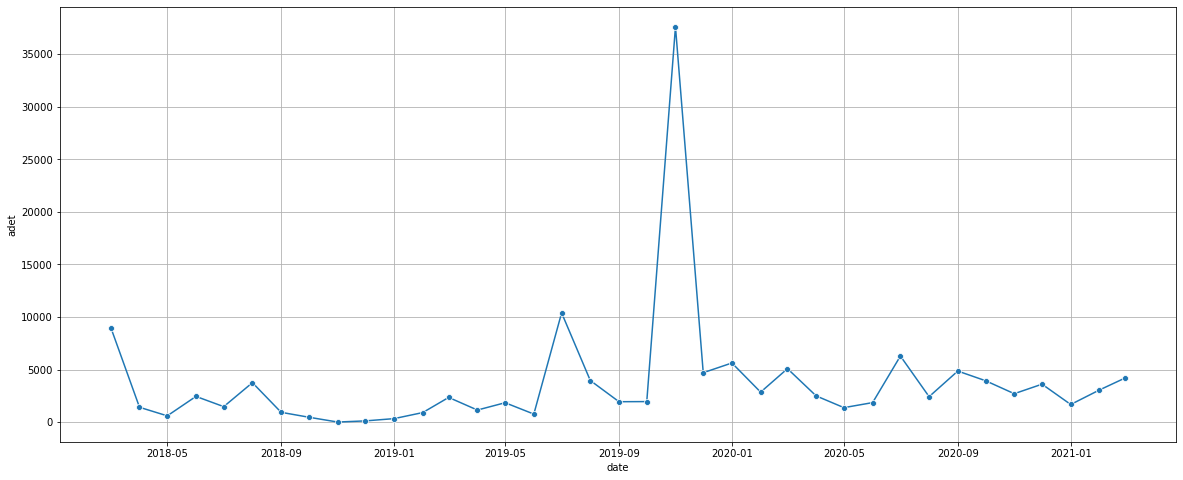

In [85]:
plt.figure(figsize=(20, 8))
sns.lineplot(x=sku3__backup.index, y=sku3__backup["adet"], data=sku3__backup, marker="o");
plt.grid()
plt.show()

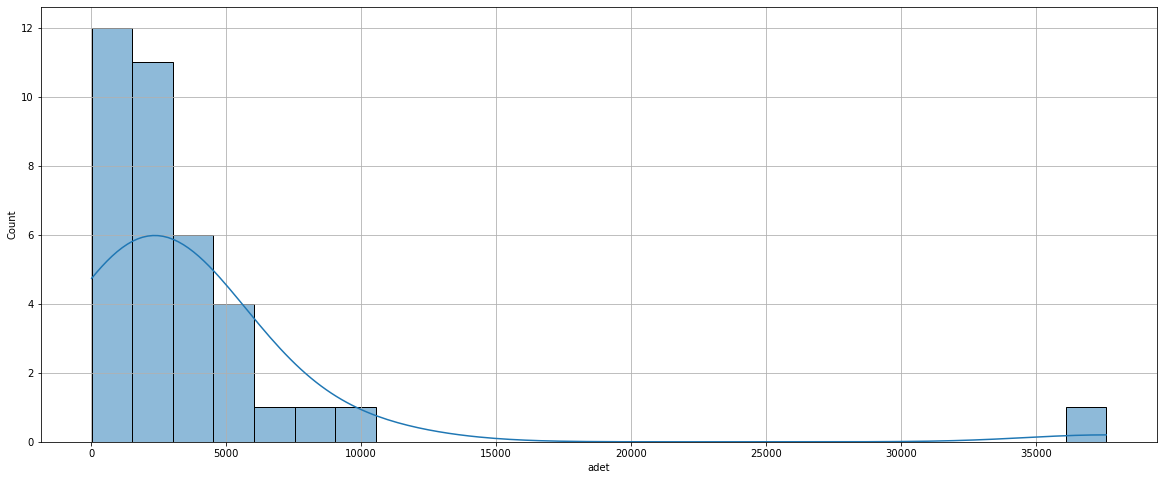

In [86]:
plt.figure(figsize=(20, 8))
sns.histplot(x="adet", data=sku3, kde=True)
plt.grid()
plt.show()

In [87]:
X3 = sku3.drop("adet", axis=1)
y3 = sku3.adet

In [88]:
idx

[Timestamp('2019-07-01 00:00:00'), Timestamp('2019-11-01 00:00:00')]

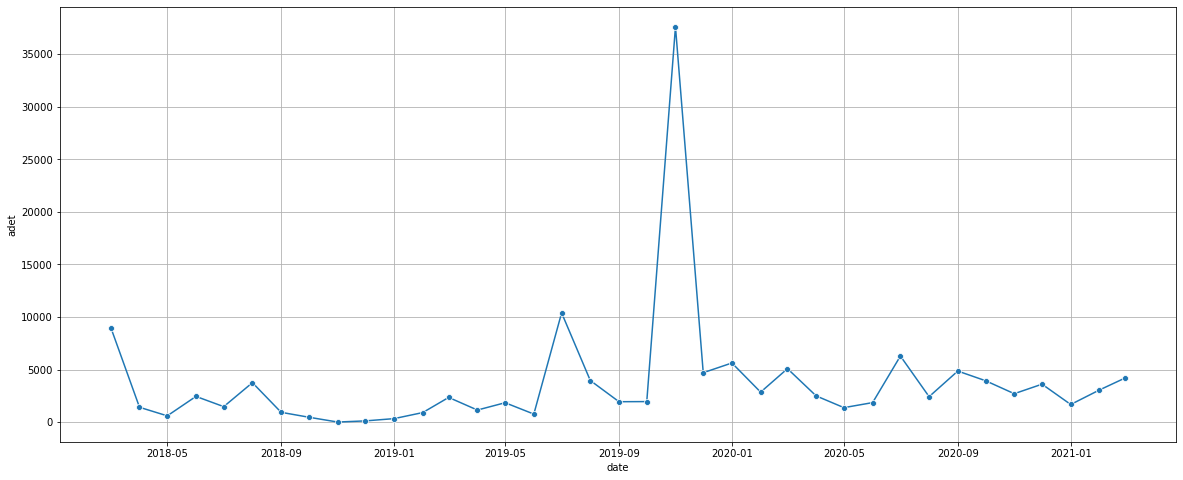

In [89]:
plt.figure(figsize=(20, 8))
sns.lineplot(x=X3.index, y=y3, data=X3, marker="o")
plt.grid()
plt.show()

In [90]:
train_size = -6
X3_train, X3_test, y3_train, y3_test = X3[:train_size], X3[train_size:], y3[:train_size], y3[train_size:]

In [91]:
X3_train.shape, X3_test.shape, y3_train.shape, y3_test.shape

((31, 2), (6, 2), (31,), (6,))

In [92]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 8

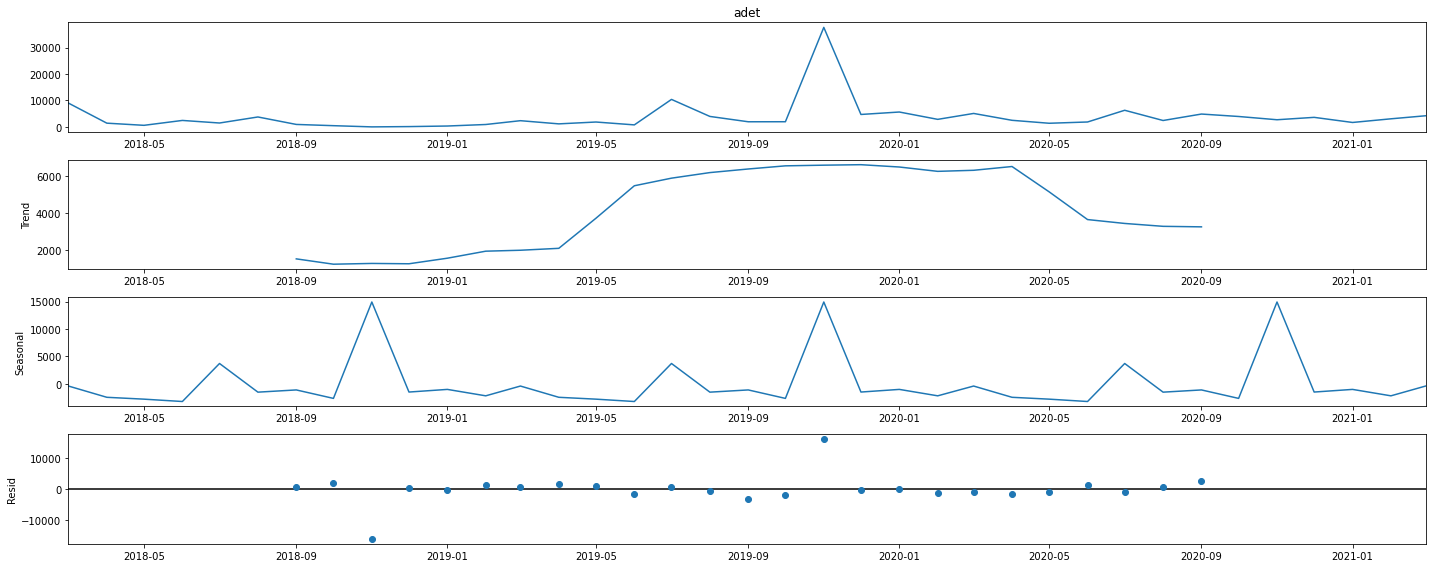

In [93]:
seas_d = sm.tsa.seasonal_decompose(y3, model="add")
seas_d.plot()
plt.show()

In [94]:
y_stationarity = y3[:train_size]
def adfuller_test_results(data):
    results = adfuller(data)
    print("ADF Statistics: %f" % results[0])
    print("p-value: %f" % results[1])
    print("Critical Values:")
    for key, value in results[4].items():
        print("\t%s: %.3f" % (key, value))
    if results[1] < 0.05:
        print("There is stationary. The data might be OK. You should also check the variance.")
    else:
        print("There is no stationary. You have to transform your data.")
adfuller_test_results(y_stationarity)

ADF Statistics: -5.231311
p-value: 0.000008
Critical Values:
	1%: -3.670
	5%: -2.964
	10%: -2.621
There is stationary. The data might be OK. You should also check the variance.


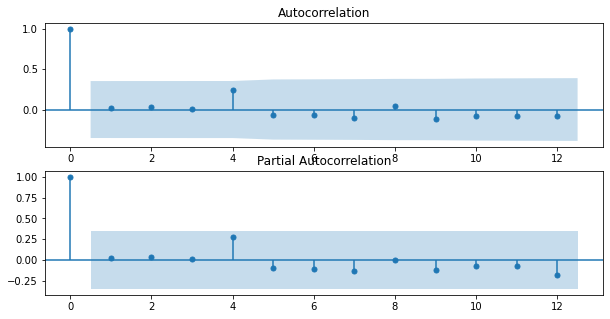

In [95]:
fig,ax= plt.subplots(2,1, figsize=(10,5))
fig=sm.tsa.graphics.plot_acf(y_stationarity, lags=12, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(y_stationarity, lags=12, ax=ax[1])
plt.show()

In [96]:
X3_train = sm.add_constant(X3_train)
X3_test = sm.add_constant(X3_test)

In [97]:
arima_model = auto_arima(y=y3_train, X=X3_train,
                        start_p=0, start_q=0,
                        max_p=13, max_q=13,m=12,
                        start_P=0, seasonal=True,
                        d=1, D=1, trace=True,
                        error_action="ignore",
                        suppress_warnings=True,
                        stepwise=True,
                        njobs=-1)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=381.549, Time=0.06 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=382.859, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=inf, Time=0.66 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.70 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.75 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=382.280, Time=0.19 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=383.948, Time=0.40 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=378.816, Time=0.11 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=379.461, Time=0.16 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.86 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=379.960, Time=0.14 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=1.25 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=379.904, Time=0.15 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.84

In [98]:
tuned_sarimax_model = sm.tsa.statespace.SARIMAX(y3_train,
                                         order=arima_model.order,
                                         seasonal_order=arima_model.seasonal_order,
                                         exog=X3_train,
                                         enforce_invertibility=False,
                                         enforce_stationarity=False)
decomposition = tuned_sarimax_model.fit()
print(decomposition.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                 adet   No. Observations:                   31
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                 -46.396
Date:                              Tue, 22 Jun 2021   AIC                            104.791
Time:                                      20:48:05   BIC                            102.448
Sample:                                  03-01-2018   HQIC                            98.502
                                       - 09-01-2020                                         
Covariance Type:                                opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0001   1.94e+06   6.05e-11      1.000    -3.8e+06     3.8e+06
p

In [99]:
try:
    X3_test.insert(loc=0, column="const", value=1.0)
except:
    pass

In [100]:
pred_uc = decomposition.get_forecast(steps=6, exog=X3_test)
pred_ci = pred_uc.conf_int()

In [101]:
predicted = decomposition.forecast(6, exog=X3_test)
y_pred3 = pd.DataFrame(predicted)
y_pred3

,predicted_mean
2020-10-01,4699.016281
2020-11-01,5605.385439
2020-12-01,5280.590234
2021-01-01,4358.801875
2021-02-01,3657.667764
2021-03-01,10327.104479


In [102]:
lower_bound = pd.DataFrame(pred_ci.iloc[:,0])
lower_bound = pd.DataFrame(lower_bound, index=pred_ci.index, columns=["lower_bound"])
lower_bound

upper_bound = pd.DataFrame(pred_ci.iloc[:,1])
upper_bound = pd.DataFrame(upper_bound, index=pred_ci.index, columns=["upper_bound"])
upper_bound

pred_ci_unscaled = pd.concat([lower_bound, upper_bound], axis=1)

In [103]:
mape3 = mean_absolute_percentage_error(sku3["adet"][y_pred3.index[0]:].values, y_pred3.values)

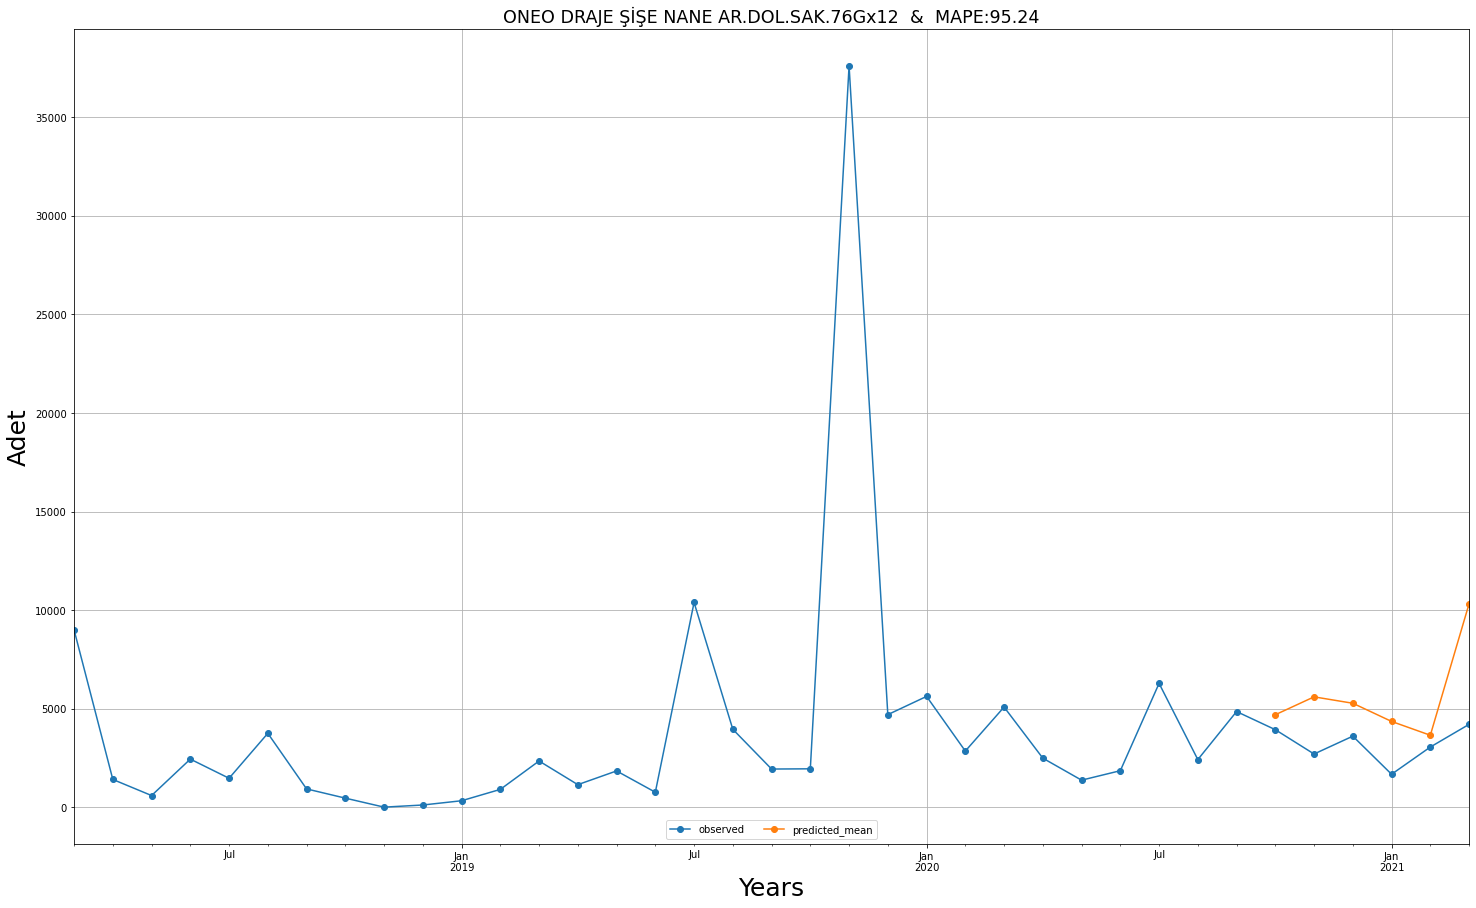

In [104]:
ax = sku3["adet"].plot(figsize=(25,15), label="observed", marker="o", y=sku3.index)
y_pred3.plot(ax=ax, label="forecast", marker="o")
ax.fill_between(pred_ci_unscaled.index,
               pred_ci_unscaled.iloc[:,0],
               pred_ci_unscaled.iloc[:,1], color="k", alpha=0.25)
ax.set_xlabel("Years", size=25)
ax.set_ylabel("Adet", size=25)
plt.legend(loc="lower center", ncol=2)
plt.title(f"ONEO DRAJE ŞİŞE NANE AR.DOL.SAK.76Gx12  &  MAPE:{mape3:.2f}", 
          size=17.5)
plt.grid()
plt.show()

In [105]:
print("MAPE:",mean_absolute_percentage_error(sku3["adet"][y_pred3.index[0]:].values, y_pred3.values))

MAPE: 95.23564984090085


In [106]:
y_pred3

,predicted_mean
2020-10-01,4699.016281
2020-11-01,5605.385439
2020-12-01,5280.590234
2021-01-01,4358.801875
2021-02-01,3657.667764
2021-03-01,10327.104479


---
# ALL ANALYSIS FOR SKU4
---

## EDA (SKU4)
---

In [107]:
sku4 = sku4__backup.copy()

In [108]:
sku4.describe().T

,count,mean,std,min,25%,50%,75%,max
adet,27.0,128867.627938,97503.910208,33060.00,68832.000,90192.00,154311.49818,410136.00
enflasyon_etkisi,27.0,14.052963,3.362911,8.55,11.765,12.62,15.95500,20.35
peak,27.0,0.111111,0.320256,0.00,0.000,0.00,0.00000,1.00
fiyat,27.0,54.795508,6.089559,48.84,48.840,53.28,60.00000,66.60
fiyat_gecisi,27.0,0.111111,0.320256,0.00,0.000,0.00,0.00000,1.00
indirim__,27.0,0.000000,0.000000,0.00,0.000,0.00,0.00000,0.00
weekdays_n,27.0,21.740741,1.059484,20.00,21.000,22.00,23.00000,23.00
weekend_n,27.0,8.666667,0.784465,8.00,8.000,8.00,9.00000,10.00
actual_holiday_n,27.0,9.592593,1.658527,8.00,9.000,9.00,10.25000,14.00
school_day_n,27.0,8.907407,9.443187,0.00,0.000,6.50,19.50000,22.00


### İndirim atıldı çünkü std mean median q1, q3'ler hep aynı

In [109]:
sku4.drop(columns=["indirim__"], axis=1, inplace=True)

In [110]:
sku4_backup = sku4.copy()

### Tekrarlamayan peak noktalarına ortalama atandı

In [111]:
idx = list(sku4[sku4["peak"] == 1].index)

In [112]:
idx

[Timestamp('2019-01-01 00:00:00'),
 Timestamp('2019-03-01 00:00:00'),
 Timestamp('2019-05-01 00:00:00')]

In [113]:
mean4 = sku4.adet.mean()

In [114]:
mean4

128867.62793777777

In [115]:
print(idx[0], sku4.loc[idx[0], "adet"])
print(idx[1], sku4.loc[idx[1], "adet"])
print(idx[1], sku4.loc[idx[1], "adet"])

2019-01-01 00:00:00 410136.0
2019-03-01 00:00:00 403920.0
2019-03-01 00:00:00 403920.0


In [284]:
sku4.loc[idx[0], "adet"] = mean4
sku4.loc[idx[1], "adet"] = mean4
sku4.loc[idx[1], "adet"] = mean4

In [285]:
sku4.drop("peak", axis=1, inplace=True)

In [116]:
sku4.corr()

,adet,enflasyon_etkisi,peak,fiyat,fiyat_gecisi,weekdays_n,weekend_n,actual_holiday_n,school_day_n,ramadan_n,pandemic,lockdown
adet,1.000000,0.538491,8.203321e-01,-0.604118,-0.151128,0.138787,-4.614394e-02,-0.087113,0.578686,0.113637,-0.506140,-0.034256
enflasyon_etkisi,0.538491,1.000000,5.932153e-01,-0.193706,-0.187091,-0.011866,-1.314085e-01,-0.100800,0.136522,0.077341,-0.298933,-0.247524
peak,0.820332,0.593215,1.000000e+00,-0.352357,-0.125000,0.201517,-1.274756e-17,-0.056320,0.372348,0.351161,-0.340693,-0.100000
fiyat,-0.604118,-0.193706,-3.523572e-01,1.000000,0.139870,-0.032610,-1.837088e-02,-0.187438,-0.583228,-0.199810,0.832295,-0.056341
fiyat_gecisi,-0.151128,-0.187091,-1.250000e-01,0.139870,1.000000,-0.251896,4.592793e-01,0.378148,-0.136363,0.296670,0.131036,0.350000
weekdays_n,0.138787,-0.011866,2.015171e-01,-0.032610,-0.251896,1.000000,-5.707412e-01,-0.237527,-0.050545,0.057954,0.026406,-0.065493
weekend_n,-0.046144,-0.131408,-1.274756e-17,-0.018371,0.459279,-0.570741,1.000000e+00,0.704556,-0.004327,0.103813,0.032097,0.122474
actual_holiday_n,-0.087113,-0.100800,-5.631990e-02,-0.187438,0.378148,-0.237527,7.045560e-01,1.000000,-0.171335,0.341768,-0.032050,0.331483
school_day_n,0.578686,0.136522,3.723475e-01,-0.583228,-0.136363,-0.050545,-4.326667e-03,-0.171335,1.000000,0.039150,-0.682293,-0.271877
ramadan_n,0.113637,0.077341,3.511606e-01,-0.199810,0.296670,0.057954,1.038129e-01,0.341768,0.039150,1.000000,0.012694,0.557013


### Histogram grafiği

In [117]:
#sku4 = sku4[["adet", "school_day_n"]]
sku4 = sku4[["adet", "enflasyon_etkisi", "peak", "school_day_n", "pandemic"]]

In [118]:
idx

[Timestamp('2019-01-01 00:00:00'),
 Timestamp('2019-03-01 00:00:00'),
 Timestamp('2019-05-01 00:00:00')]

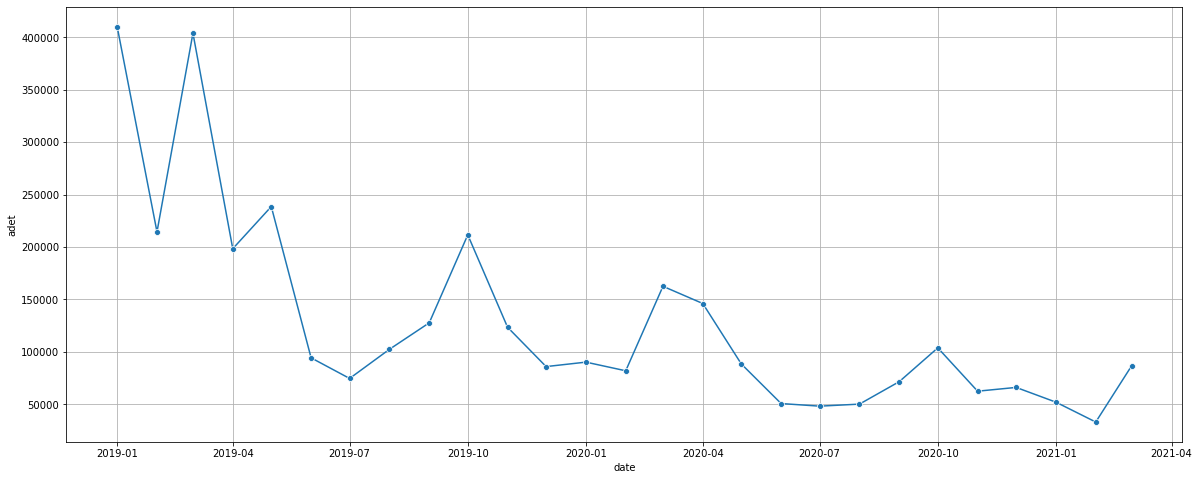

In [119]:
plt.figure(figsize=(20, 8))
sns.lineplot(x=sku4__backup.index, y=sku4__backup["adet"], data=sku4__backup, marker="o");
plt.grid()
plt.show()

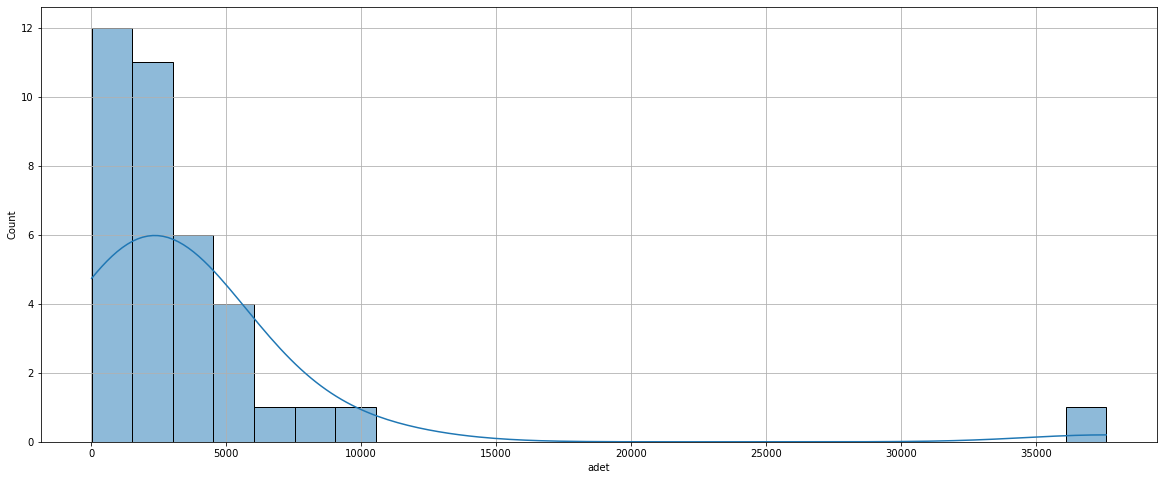

In [120]:
plt.figure(figsize=(20, 8))
sns.histplot(x="adet", data=sku3, kde=True)
plt.grid()
plt.show()

In [121]:
X4 = sku4.drop("adet", axis=1)
y4 = sku4.adet

In [122]:
idx

[Timestamp('2019-01-01 00:00:00'),
 Timestamp('2019-03-01 00:00:00'),
 Timestamp('2019-05-01 00:00:00')]

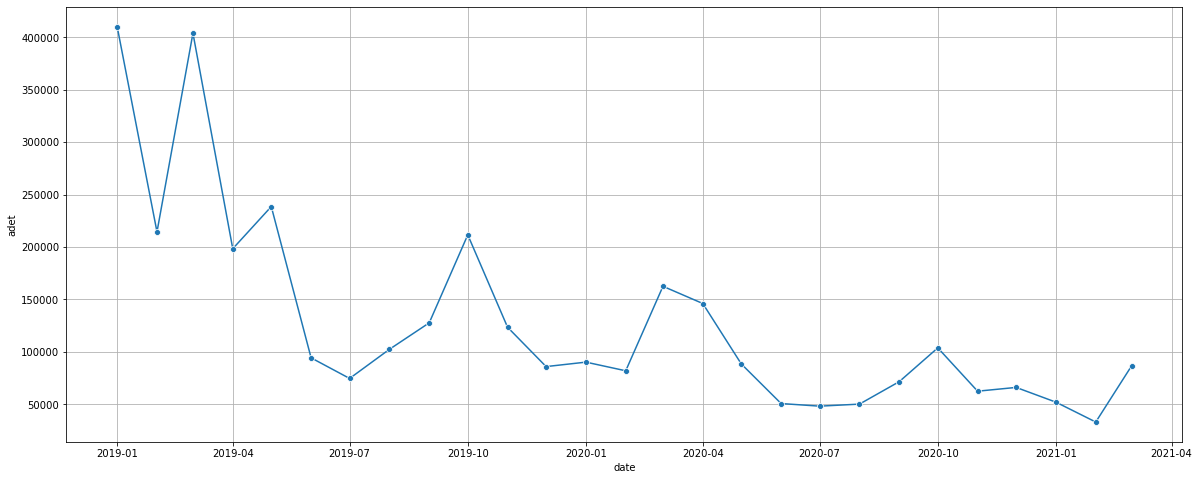

In [123]:
plt.figure(figsize=(20, 8))
sns.lineplot(x=X4.index, y=y4, data=X4, marker="o")
plt.grid()
plt.show()

In [124]:
train_size = -6
X4_train, X4_test, y4_train, y4_test = X4[:train_size], X4[train_size:], y4[:train_size], y4[train_size:]

In [125]:
X4_train.shape, X4_test.shape, y4_train.shape, y4_test.shape

((21, 4), (6, 4), (21,), (6,))

In [126]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 8

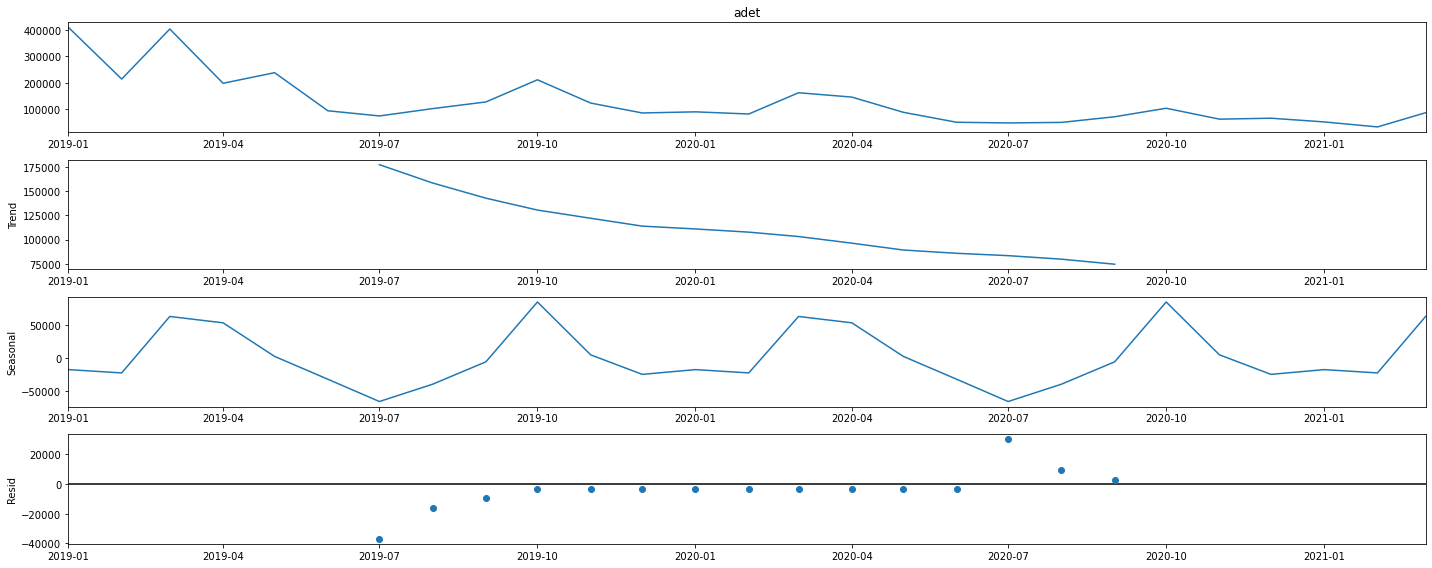

In [127]:
seas_d = sm.tsa.seasonal_decompose(y4, model="add")
seas_d.plot()
plt.show()

In [129]:
y_stationarity = y4[:train_size]
def adfuller_test_results(data):
    results = adfuller(data)
    print("ADF Statistics: %f" % results[0])
    print("p-value: %f" % results[1])
    print("Critical Values:")
    for key, value in results[4].items():
        print("\t%s: %.3f" % (key, value))
    if results[1] < 0.05:
        print("There is stationary. The data might be OK. You should also check the variance.")
    else:
        print("There is no stationary. You have to transform your data.")
adfuller_test_results(y_stationarity)

ADF Statistics: 2.215175
p-value: 0.998895
Critical Values:
	1%: -4.069
	5%: -3.127
	10%: -2.702
There is no stationary. You have to transform your data.


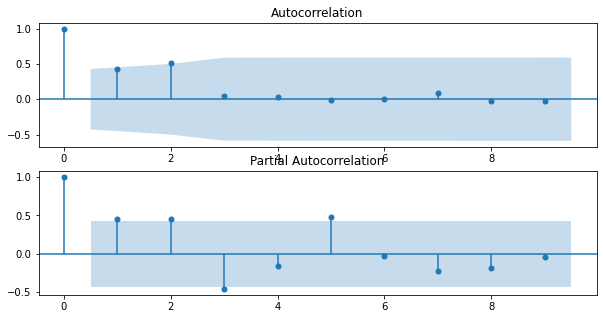

In [130]:
fig,ax= plt.subplots(2,1, figsize=(10,5))
fig=sm.tsa.graphics.plot_acf(y_stationarity, lags=9, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(y_stationarity, lags=9, ax=ax[1])
plt.show()

In [131]:
X4_train = sm.add_constant(X4_train)
X4_test = sm.add_constant(X4_test)

In [132]:
arima_model = auto_arima(y=y4_train, X=X4_train,
                        start_p=0, start_q=0,
                        max_p=13, max_q=13,m=12,
                        start_P=0, seasonal=True,
                        d=1, D=1, trace=True,
                        error_action="ignore",
                        suppress_warnings=True,
                        stepwise=True,
                        njobs=-1)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=192.620, Time=0.07 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=208.168, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=194.152, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=187.230, Time=0.11 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=206.228, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=187.562, Time=0.59 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=189.004, Time=0.21 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=186.980, Time=0.10 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=188.980, Time=0.19 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=190.980, Time=0.26 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=192.808, Time=0.10 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=192.025, Time=0.21 sec
 ARIMA(0,1,2)(1,1,0)[12]             : AIC=inf, Time=nan sec
 ARIMA(1,1,2)(1,1,0)[12]             : AIC=inf, Time=nan sec
 ARIMA(0,1,1)(1,1,0)[12] intercept   : AIC=

In [133]:
tuned_sarimax_model = sm.tsa.statespace.SARIMAX(y4_train,
                                         order=arima_model.order,
                                         seasonal_order=arima_model.seasonal_order,
                                         exog=X4_train,
                                         enforce_invertibility=False,
                                         enforce_stationarity=False)
decomposition = tuned_sarimax_model.fit()
print(decomposition.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                adet   No. Observations:                   21
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 12)   Log Likelihood                   0.000
Date:                             Tue, 22 Jun 2021   AIC                             16.000
Time:                                     20:49:43   BIC                                nan
Sample:                                 01-01-2019   HQIC                               nan
                                      - 09-01-2020                                         
Covariance Type:                               opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                     0         -0        nan        nan           0           0
enflasyon

In [134]:
try:
    X4_test.insert(loc=0, column="const", value=1.0)
except:
    pass

In [135]:
pred_uc = decomposition.get_forecast(steps=6, exog=X4_test)
pred_ci = pred_uc.conf_int()

In [136]:
predicted = decomposition.forecast(6, exog=X4_test)
y_pred4 = pd.DataFrame(predicted)
y_pred4

,predicted_mean
2020-10-01,127960.001735
2020-11-01,63081.981160
2020-12-01,38252.937037
2021-01-01,26352.518261
2021-02-01,28953.035698
2021-03-01,67131.541868


In [137]:
lower_bound = pd.DataFrame(pred_ci.iloc[:,0])
lower_bound = pd.DataFrame(lower_bound, index=pred_ci.index, columns=["lower_bound"])
lower_bound

upper_bound = pd.DataFrame(pred_ci.iloc[:,1])
upper_bound = pd.DataFrame(upper_bound, index=pred_ci.index, columns=["upper_bound"])
upper_bound

pred_ci_unscaled = pd.concat([lower_bound, upper_bound], axis=1)

In [138]:
mape4 = mean_absolute_percentage_error(sku4["adet"][y_pred4.index[0]:].values, y_pred4.values)

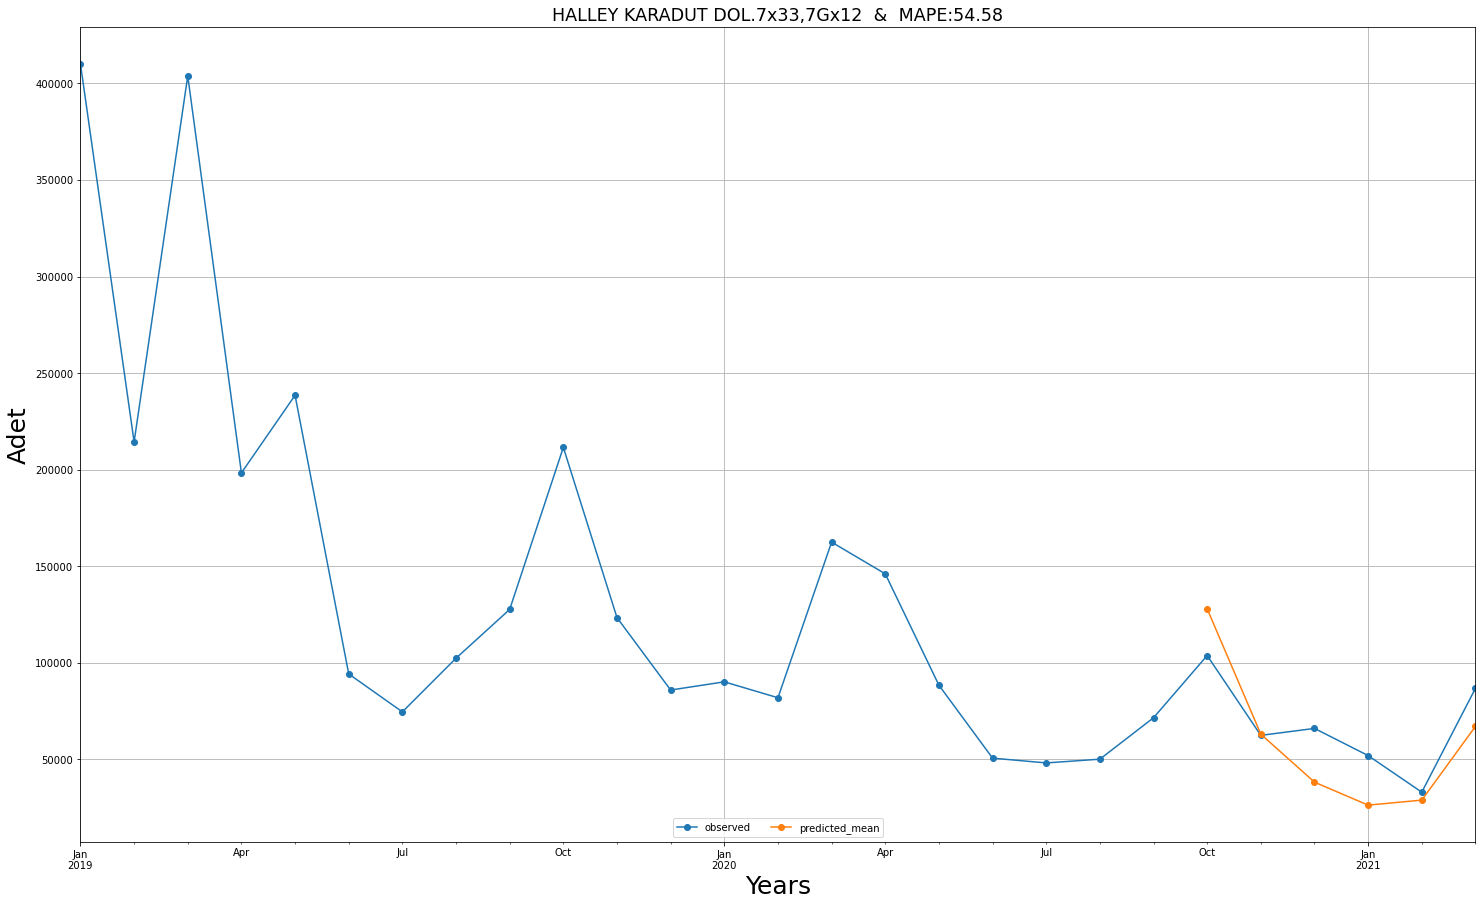

In [139]:
ax = sku4["adet"].plot(figsize=(25,15), label="observed", marker="o", y=sku4.index)
y_pred4.plot(ax=ax, label="forecast", marker="o")
ax.fill_between(pred_ci_unscaled.index,
               pred_ci_unscaled.iloc[:,0],
               pred_ci_unscaled.iloc[:,1], color="k", alpha=0.25)
ax.set_xlabel("Years", size=25)
ax.set_ylabel("Adet", size=25)
plt.legend(loc="lower center", ncol=2)
plt.title(f"HALLEY KARADUT DOL.7x33,7Gx12  &  MAPE:{mape4:.2f}", 
          size=17.5)
plt.grid()
plt.show()

In [140]:
print("MAPE:",mean_absolute_percentage_error(sku4["adet"][y_pred4.index[0]:].values, y_pred4.values))

MAPE: 54.58006577930734


In [141]:
y_pred4

,predicted_mean
2020-10-01,127960.001735
2020-11-01,63081.981160
2020-12-01,38252.937037
2021-01-01,26352.518261
2021-02-01,28953.035698
2021-03-01,67131.541868


---
# ALL ANALYSIS FOR SKU5
---

## EDA (SKU5)
---

In [455]:
sku5 = sku5__backup.copy()

In [456]:
sku5.describe().T

,count,mean,std,min,25%,50%,75%,max
adet,51.0,23308.117830,35880.353462,83.00166,10078.00038,15265.00,25791.000,244512.00000
enflasyon_etkisi,51.0,13.876275,4.035855,8.55000,11.07000,11.92,15.785,25.24000
peak,51.0,0.039216,0.196039,0.00000,0.00000,0.00,0.000,1.00000
fiyat,31.0,39.042194,5.366917,32.22000,34.58800,40.02,43.320,47.76000
fiyat_gecisi,31.0,0.129032,0.340777,0.00000,0.00000,0.00,0.000,1.00000
indirim__,51.0,0.005450,0.027335,0.00000,0.00000,0.00,0.000,0.14997
weekdays_n,51.0,21.725490,1.059782,20.00000,21.00000,22.00,23.000,23.00000
weekend_n,51.0,8.686275,0.787152,8.00000,8.00000,8.00,9.000,10.00000
actual_holiday_n,51.0,9.558824,1.518707,8.00000,9.00000,9.00,10.000,14.00000
school_day_n,51.0,11.656863,9.394940,0.00000,0.00000,14.00,21.000,23.00000


### İndirim atıldı çünkü std mean median q1, q3'ler hep aynı

In [457]:
sku5.drop(columns=["indirim__"], axis=1, inplace=True)

In [458]:
sku5_backup = sku5.copy()

### Tekrarlamayan peak noktalarına ortalama atandı

In [459]:
idx = list(sku5[sku5["peak"] == 1].index)

In [460]:
idx

[Timestamp('2021-01-01 00:00:00'), Timestamp('2021-02-01 00:00:00')]

In [461]:
mean5 = sku5.adet.mean()

In [462]:
mean5

23308.117829803927

In [463]:
print(idx[0], sku5.loc[idx[0], "adet"])
print(idx[1], sku5.loc[idx[1], "adet"])

2021-01-01 00:00:00 244512.0
2021-02-01 00:00:00 115986.0042


In [464]:
sku5.loc[idx[0], "adet"] = mean5
sku5.loc[idx[1], "adet"] = mean5

In [465]:
sku5.drop("peak", axis=1, inplace=True)

In [466]:
sku5.corr()

,adet,enflasyon_etkisi,fiyat,fiyat_gecisi,weekdays_n,weekend_n,actual_holiday_n,school_day_n,ramadan_n,pandemic,lockdown
adet,1.000000,-0.100694,0.105753,0.027858,0.032227,-0.219053,-0.112624,-0.129599,-0.275961,0.349859,0.163128
enflasyon_etkisi,-0.100694,1.000000,-0.486221,-0.058579,0.005227,-0.001823,-0.014549,0.059380,-0.025822,-0.123980,-0.137074
fiyat,0.105753,-0.486221,1.000000,0.076534,0.008220,-0.051807,-0.040600,-0.696246,-0.042193,0.814525,0.048637
fiyat_gecisi,0.027858,-0.058579,0.076534,1.000000,-0.091747,-0.099518,-0.187419,-0.052349,-0.122107,0.062904,-0.101080
weekdays_n,0.032227,0.005227,0.008220,-0.091747,1.000000,-0.584797,-0.163734,-0.029737,0.102289,0.024381,-0.043414
weekend_n,-0.219053,-0.001823,-0.051807,-0.099518,-0.584797,1.000000,0.534378,-0.032427,-0.054292,0.004528,0.081322
actual_holiday_n,-0.112624,-0.014549,-0.040600,-0.187419,-0.163734,0.534378,1.000000,-0.310440,0.239875,-0.007920,0.260800
school_day_n,-0.129599,0.059380,-0.696246,-0.052349,-0.029737,-0.032427,-0.310440,1.000000,-0.026683,-0.585422,-0.253166
ramadan_n,-0.275961,-0.025822,-0.042193,-0.122107,0.102289,-0.054292,0.239875,-0.026683,1.000000,-0.002368,0.404094
pandemic,0.349859,-0.123980,0.814525,0.062904,0.024381,0.004528,-0.007920,-0.585422,-0.002368,1.000000,0.345412


In [467]:
sku5 = sku5[["adet", "pandemic"]]
#sku5 = sku5[["adet", "peak", "pandemic", "school_day_n"]]

### Histogram grafiği

In [468]:
idx

[Timestamp('2021-01-01 00:00:00'), Timestamp('2021-02-01 00:00:00')]

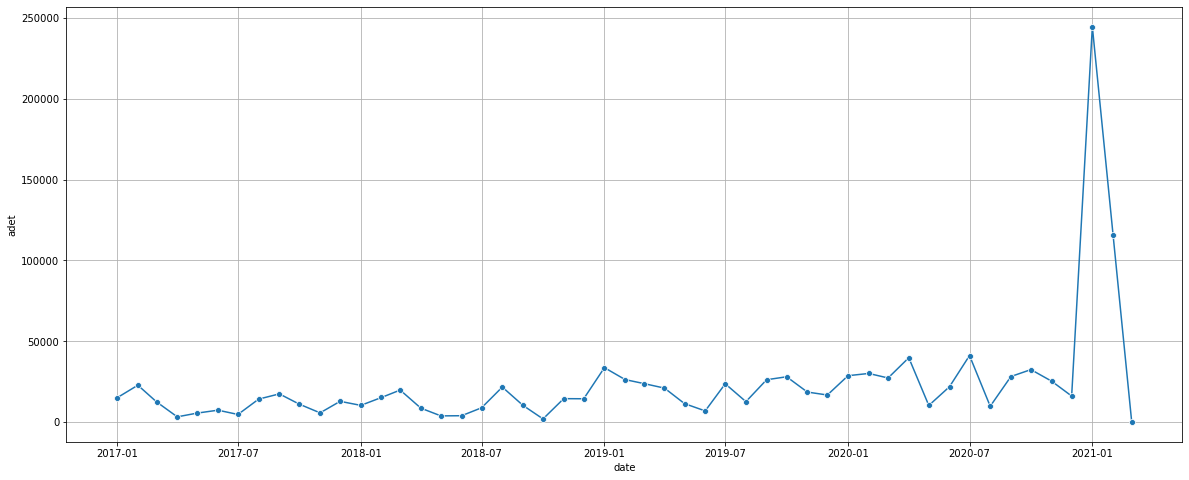

In [469]:
plt.figure(figsize=(20, 8))
sns.lineplot(x=sku5__backup.index, y=sku5__backup["adet"], data=sku5__backup, marker="o");
plt.grid()
plt.show()

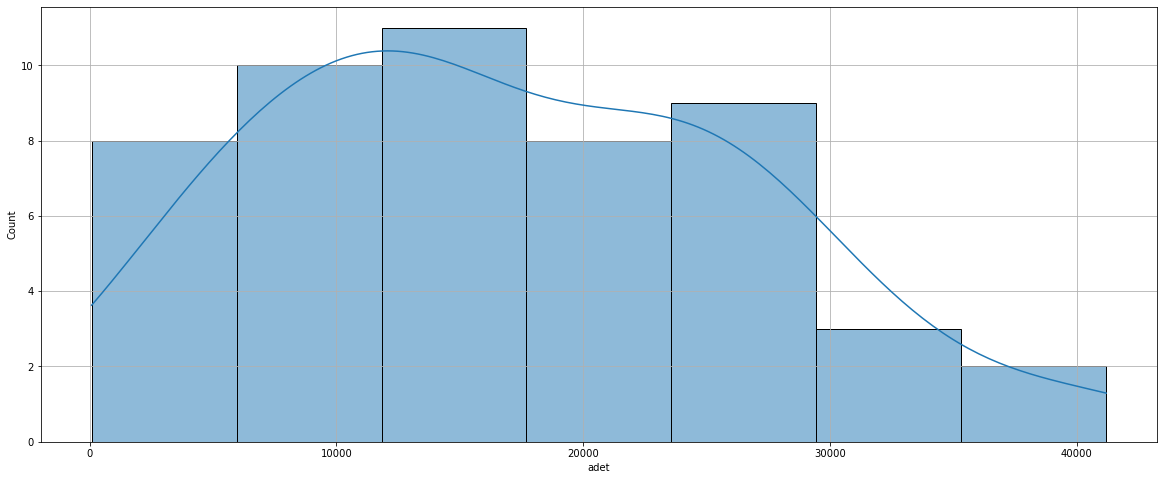

In [470]:
plt.figure(figsize=(20, 8))
sns.histplot(x="adet", data=sku5, kde=True)
plt.grid()
plt.show()

In [471]:
X5 = sku5.drop("adet", axis=1)
y5 = sku5.adet

In [472]:
y5 = np.log(y5)

In [473]:
idx

[Timestamp('2021-01-01 00:00:00'), Timestamp('2021-02-01 00:00:00')]

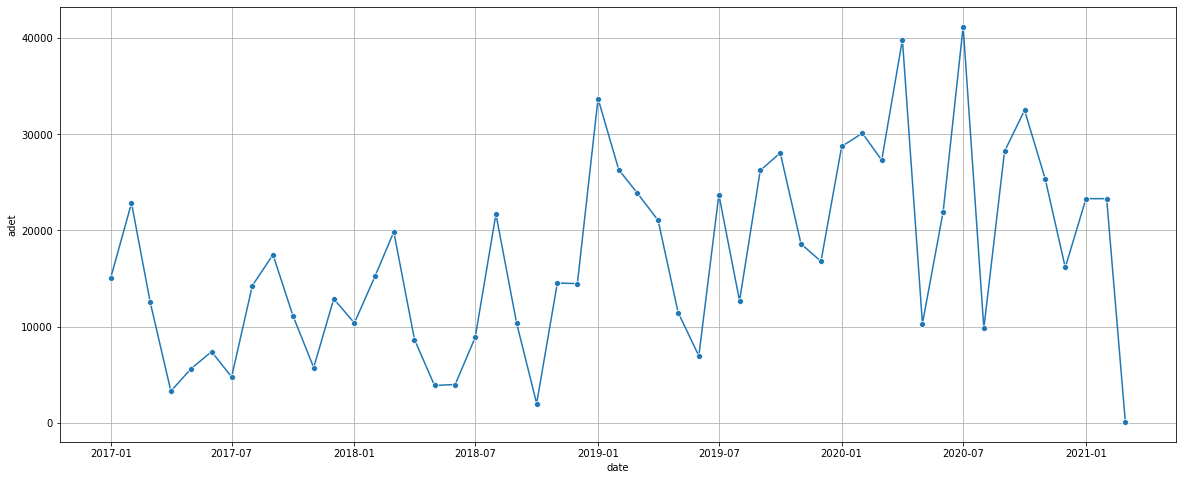

In [475]:
plt.figure(figsize=(20, 8))
sns.lineplot(x=sku5.index, y="adet", data=sku5, marker="o")
plt.grid()
plt.show()

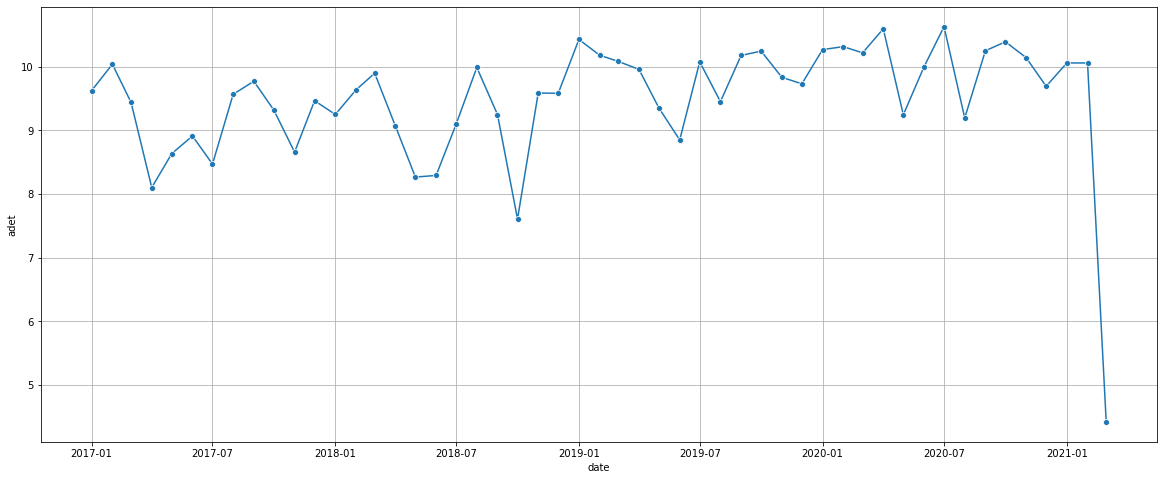

In [474]:
plt.figure(figsize=(20, 8))
sns.lineplot(x=X5.index, y=y5, data=X5, marker="o")
plt.grid()
plt.show()

In [412]:
train_size = -6
X5_train, X5_test, y5_train, y5_test = X5[:train_size], X5[train_size:], y5[:train_size], y5[train_size:]

In [413]:
X5_train.shape, X5_test.shape, y5_train.shape, y5_test.shape

((45, 1), (6, 1), (45,), (6,))

In [414]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 8

In [415]:
y_stationarity = y5[:train_size]
def adfuller_test_results(data):
    results = adfuller(data)
    print("ADF Statistics: %f" % results[0])
    print("p-value: %f" % results[1])
    print("Critical Values:")
    for key, value in results[4].items():
        print("\t%s: %.3f" % (key, value))
    if results[1] < 0.05:
        print("There is stationary. The data might be OK. You should also check the variance.")
    else:
        print("There is no stationary. You have to transform your data.")
adfuller_test_results(y_stationarity)

ADF Statistics: -4.190317
p-value: 0.000684
Critical Values:
	1%: -3.589
	5%: -2.930
	10%: -2.603
There is stationary. The data might be OK. You should also check the variance.


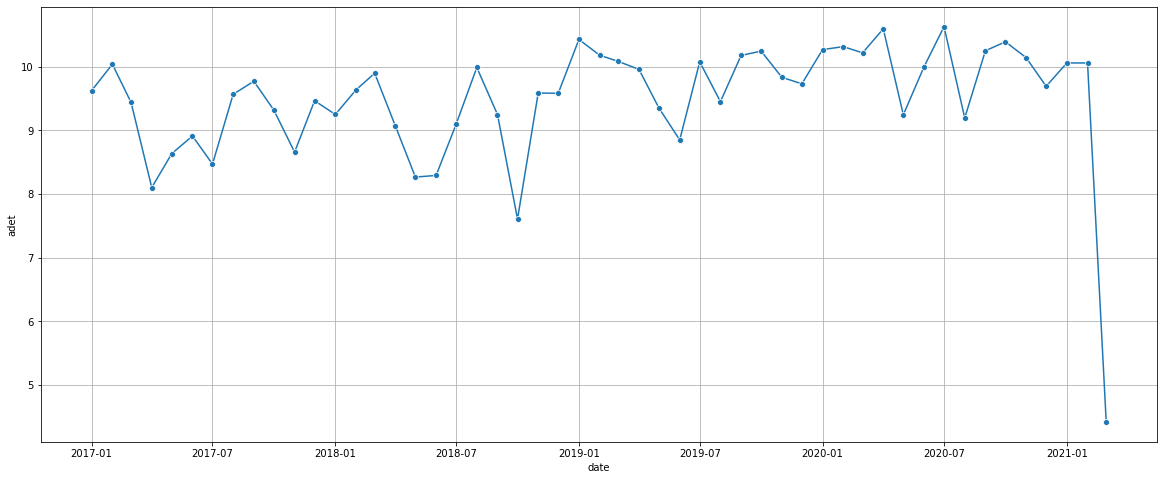

In [416]:
plt.figure(figsize=(20, 8))
sns.lineplot(x=X5.index, y=y5, data=y5, marker="o")
plt.grid()
plt.show()

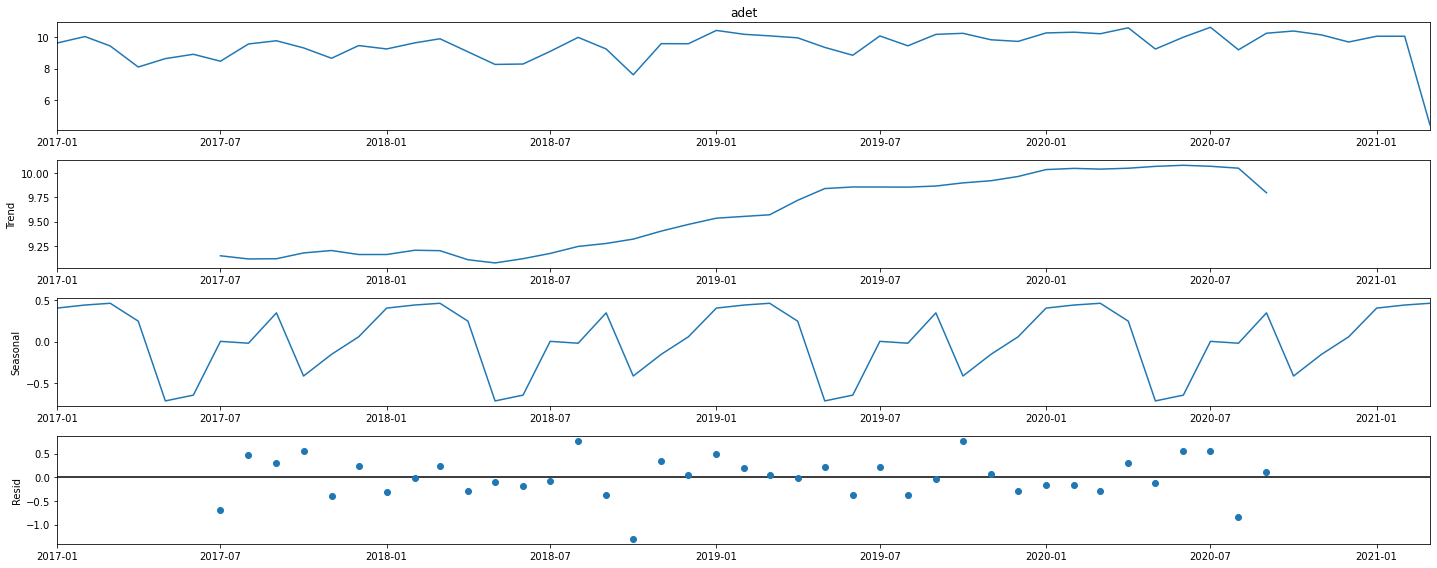

In [417]:
seas_d = sm.tsa.seasonal_decompose(y5, model="add")
seas_d.plot()
plt.show()

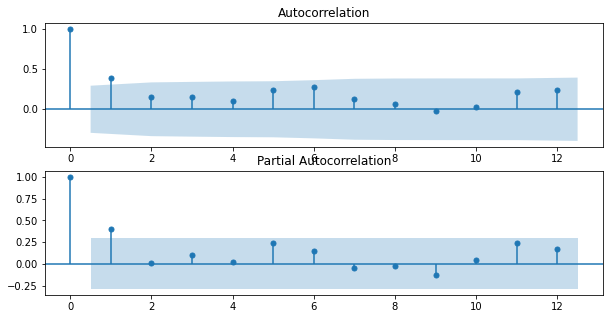

In [418]:
fig,ax= plt.subplots(2,1, figsize=(10,5))
fig=sm.tsa.graphics.plot_acf(y_stationarity, lags=12, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(y_stationarity, lags=12, ax=ax[1])
plt.show()

In [419]:
X5_train = sm.add_constant(X5_train)
X5_test = sm.add_constant(X5_test)

In [420]:
arima_model = auto_arima(y=y5_train, X=X5_train,
                        start_p=0, start_q=0,
                        max_p=13, max_q=13,m=12,
                        start_P=0, seasonal=True,
                        d=1, D=1, trace=True,
                        error_action="ignore",
                        suppress_warnings=True,
                        stepwise=True,
                        njobs=-1)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=97.150, Time=0.22 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=98.510, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=92.589, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.31 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=95.992, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=94.364, Time=0.31 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=94.365, Time=0.27 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=93.301, Time=0.16 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=96.364, Time=0.34 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=96.562, Time=0.09 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=86.076, Time=0.18 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=92.501, Time=0.07 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=87.804, Time=0.28 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=87.831, Time=0.33 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=87.413,

In [421]:
tuned_sarimax_model = sm.tsa.statespace.SARIMAX(y5_train,
                                         order=arima_model.order,
                                         seasonal_order=arima_model.seasonal_order,
                                         exog=X5_train,
                                         enforce_invertibility=False,
                                         enforce_stationarity=False)
decomposition = tuned_sarimax_model.fit()
print(decomposition.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                adet   No. Observations:                   45
Model:             SARIMAX(2, 1, 1)x(1, 1, [], 12)   Log Likelihood                 -15.082
Date:                             Tue, 22 Jun 2021   AIC                             44.165
Time:                                     21:24:19   BIC                             50.397
Sample:                                 01-01-2017   HQIC                            45.024
                                      - 09-01-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.155e-07   9.69e+05  -4.29e-13      1.000    -1.9e+06     1.9e+06
pandemic       0.0446      

In [422]:
try:
    X5_test.insert(loc=0, column="const", value=1.0)
except:
    pass

In [423]:
pred_uc = decomposition.get_forecast(steps=6, exog=X5_test)
pred_ci = pred_uc.conf_int()

In [424]:
predicted = decomposition.forecast(6, exog=X5_test)
y_pred5 = pd.DataFrame(predicted)
y_pred5

,predicted_mean
2020-10-01,10.098468
2020-11-01,10.207145
2020-12-01,10.025535
2021-01-01,11.320633
2021-02-01,11.072755
2021-03-01,10.685138


In [425]:
lower_bound = pd.DataFrame(pred_ci.iloc[:,0])
lower_bound = pd.DataFrame(lower_bound, index=pred_ci.index, columns=["lower_bound"])
lower_bound

upper_bound = pd.DataFrame(pred_ci.iloc[:,1])
upper_bound = pd.DataFrame(upper_bound, index=pred_ci.index, columns=["upper_bound"])
upper_bound

pred_ci_unscaled = pd.concat([lower_bound, upper_bound], axis=1)

In [431]:
mape5 = mean_absolute_percentage_error(y5[y_pred5.index[0]:].values, y_pred5.values)

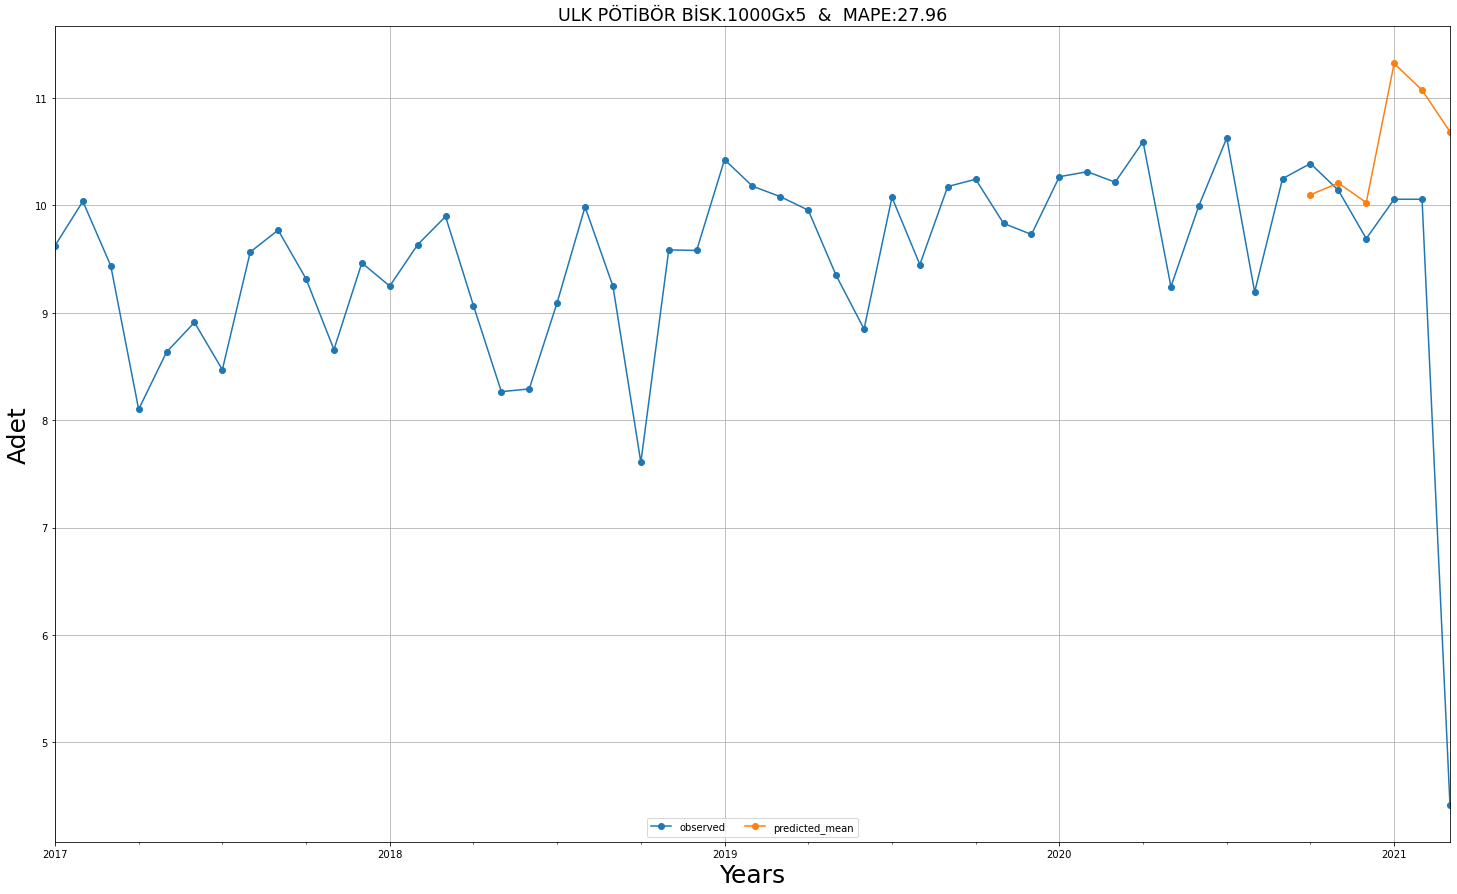

In [432]:
ax = y5.plot(figsize=(25,15), label="observed", marker="o", y=sku5.index)
y_pred5.plot(ax=ax, label="forecast", marker="o")
ax.fill_between(pred_ci_unscaled.index,
               pred_ci_unscaled.iloc[:,0],
               pred_ci_unscaled.iloc[:,1], color="k", alpha=0.25)
ax.set_xlabel("Years", size=25)
ax.set_ylabel("Adet", size=25)
plt.legend(loc="lower center", ncol=2)
plt.title(f"ULK PÖTİBÖR BİSK.1000Gx5  &  MAPE:{mape5:.2f}", 
          size=17.5)
plt.grid()
plt.show()

In [435]:
print("MAPE:",mean_absolute_percentage_error(y5[y_pred5.index[0]:].values, y_pred5.values))

MAPE: 27.958949876037543


In [454]:
print("MAPE:",
      mean_absolute_percentage_error(sku5["adet"][y_pred5.index[0]:].values, np.exp(y_pred5["predicted_mean"].values)))

MAPE: 8842.276159274365
